In [60]:
from fredapi import Fred
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import aqms
import importlib
importlib.reload(aqms)
import warnings
warnings.filterwarnings("ignore")

## Preprocessing data
Loading Spot exchange data for top 10 free floating currencies in terms of liquidity from Fred, and also futures data from Bloomberg terminal. CPI index was also downoaded from Fred. 

In [61]:
spot_df = pd.read_csv("fx_data.csv", index_col=0)
spot_df.index = pd.to_datetime(spot_df.index).to_period("M")
spot_df

,EUR/USD,USD/CAD,GBP/USD,USD/CHF,USD/NOK,USD/SEK,NZD/USD,USD/DKK
1999-01,1.1591,1.5194,1.6498,1.3856,7.4532,7.8188,0.5388,6.4194
1999-02,1.1203,1.4977,1.6276,1.4272,7.7240,7.9532,0.5435,6.6379
1999-03,1.0886,1.5176,1.6213,1.4660,7.8151,8.2144,0.5323,6.8287
1999-04,1.0701,1.4881,1.6089,1.4971,7.7750,8.3293,0.5427,6.9475
1999-05,1.0630,1.4611,1.6154,1.5078,7.7496,8.4432,0.5530,6.9925
...,...,...,...,...,...,...,...,...
2024-12,1.0472,1.4247,1.2647,0.8916,11.2204,10.9850,0.5748,7.1221
2025-01,1.0356,1.4389,1.2354,0.9096,11.3335,11.0845,0.5633,7.2047
2025-02,1.0413,1.4299,1.2542,0.9034,11.1934,10.7936,0.5680,7.1633
2025-03,1.0813,1.4356,1.2913,0.8836,10.6782,10.1328,0.5727,6.8993


In [62]:
# Only keep first of the month:
def filter_first(df):
    df.index = pd.to_datetime(df.index)
    keep_idxs = []
    for ym, group in df.groupby(df.index.to_period('M')):
        # find all rows in this group where day == 1
        first_day = group[group.index.day == 1]
        if not first_day.empty:
            # take the first-1st‐of‐month row
            keep_idxs.append(first_day.index[0])
        else:
            # otherwise take the group’s earliest date
            keep_idxs.append(group.index.min())
    
    # (3) Subset the original DataFrame
    df_filtered = df.loc[keep_idxs].sort_index()
    df_filtered.index = df_filtered.index.to_period("M")
    return df_filtered


In [63]:
# Get all the points dataframes
eurusd_df = pd.read_excel('EURUSD.xlsx', engine='openpyxl', index_col=0)
eurusd_df = eurusd_df.iloc[7:, 0]
eurusd_df = filter_first(eurusd_df)

gbpusd_df = pd.read_excel('GBPUSD.xlsx', engine='openpyxl', index_col=0)
gbpusd_df = gbpusd_df.iloc[7:, 0]
gbpusd_df = filter_first(gbpusd_df)

usdnok_df = pd.read_excel('USDNOK.xlsx', engine='openpyxl', index_col=0)
usdnok_df = usdnok_df.iloc[7:, 0]
usdnok_df = filter_first(usdnok_df)

usddkk_df = pd.read_excel('USDDKK.xlsx', engine='openpyxl', index_col=0)
usddkk_df = usddkk_df.iloc[7:, 0]
usddkk_df = filter_first(usddkk_df)

usdchf_df = pd.read_excel('USDCHF.xlsx', engine='openpyxl', index_col=0)
usdchf_df = usdchf_df.iloc[7:, 0]
usdchf_df = filter_first(usdchf_df)

usdcad_df = pd.read_excel('USDCAD.xlsx', engine='openpyxl', index_col=0)
usdcad_df = usdcad_df.iloc[7:, 0]
usdcad_df = filter_first(usdcad_df)

usdsek_df = pd.read_excel('USDSEK.xlsx', engine='openpyxl', index_col=0)
usdsek_df = usdsek_df.iloc[7:, 0]
usdsek_df = filter_first(usdsek_df)

nzdusd_df = pd.read_excel('NZDUSD.xlsx', engine='openpyxl', index_col=0)
nzdusd_df = nzdusd_df.iloc[7:, 0]
nzdusd_df = filter_first(nzdusd_df)

points_df = pd.concat([eurusd_df, usdcad_df, gbpusd_df, usdchf_df, usdnok_df, usdsek_df, nzdusd_df, usddkk_df], axis=1)
points_df.columns = ["EUR/USD", "USD/CAD", "GBP/USD", "USD/CHF", "USD/NOK", "USD/SEK", "NZD/USD", "USD/DKK"]
points_df

,EUR/USD,USD/CAD,GBP/USD,USD/CHF,USD/NOK,USD/SEK,NZD/USD,USD/DKK
Security,,,,,,,,
1999-01,18.3,-0.95,-16.5,-45.6,212.5,-116.5,3.5,-55.15
1999-02,15.35,1.05,-12.15,-41,172,-94,6.15,-63.06
1999-03,17.35,1.55,-8.6,-51.1,206.5,-125.5,1.5,-96.71
1999-04,18.05,-1.75,-5.15,-46,135,-131,2,-91.5
1999-05,22,-1.25,-5.4,-54.25,145,-141.5,1.65,-113.5
...,...,...,...,...,...,...,...,...
2025-02,13.26,-16.94,-0.93,-28.7,4.05,-188.26,1.96,-111.72
2025-03,17.58,-20.23,-0.99,-34.13,-4.59,-213.32,2.95,-136.5
2025-04,18.78,-21.35,-1.04,-33.62,0.12,-193.63,4.48,-134.21


In [64]:
full_df = pd.concat({"spot": spot_df, "points": points_df},axis=1)
full_df = full_df.swaplevel(0, 1, axis=1)
full_df = full_df.sort_index(axis=1, level=0)

for ccy in full_df.columns.levels[0]:
    full_df[(ccy, 'fwd raw')] = full_df[(ccy, 'spot')] + 0.0001 * full_df[(ccy, 'points')]
full_df = full_df.sort_index(axis=1, level=0)
currencies = full_df.columns.get_level_values(0).unique()
suborder = ['spot','points','fwd raw']
new_col_tuples = [(ccy, sub) for ccy in currencies for sub in suborder]
full_df = full_df.loc[:, new_col_tuples]

for ccy in full_df.columns.get_level_values(0).unique():
    fwd = full_df[(ccy, "fwd raw")]
    spot = full_df[(ccy, "spot")]
    if ccy.startswith("USD/"):
        full_df[(ccy, "spot USD base")] = spot
        full_df[(ccy, "fwd USD base")] = fwd
    elif ccy.endswith("/USD"):
        full_df[(ccy, "spot USD base")] = 1.0 / spot
        full_df[(ccy, "fwd USD base")] = 1.0 / fwd

currencies = full_df.columns.get_level_values(0).unique()
suborder = ["spot", "points", "fwd raw", "spot USD base", "fwd USD base"]
new_tuples = [(ccy, sub) for ccy in currencies for sub in suborder]
full_df = full_df.loc[:, new_tuples]
new_outer = ["USD/EUR", "USD/CAD", "USD/GBP", "USD/CHF", "USD/NOK", "USD/SEK", "USD/NZD", "USD/DKK"]
full_df.columns = pd.MultiIndex.from_tuples([
    (new_outer[i // 5], col[1]) for i, col in enumerate(full_df.columns)
])
full_df

USD/EUR                                             USD/CAD         \
           spot points   fwd raw spot USD base fwd USD base    spot points   
1999-01  1.1591   18.3   1.16093      0.862738     0.861378  1.6498  -16.5   
1999-02  1.1203  15.35  1.121835      0.892618     0.891397  1.6276 -12.15   
1999-03  1.0886  17.35  1.090335      0.918611     0.917149  1.6213   -8.6   
1999-04  1.0701  18.05  1.071905      0.934492     0.932918  1.6089  -5.15   
1999-05  1.0630     22    1.0652      0.940734     0.938791  1.6154   -5.4   
...         ...    ...       ...           ...          ...     ...    ...   
2025-02  1.0413  13.26  1.042626      0.960338     0.959117  1.2542  -0.93   
2025-03  1.0813  17.58  1.083058      0.924813     0.923312  1.2913  -0.99   
2025-04  1.1232  18.78  1.125078      0.890313     0.888827  1.3144  -1.04   
2025-05     NaN  21.17       NaN           NaN          NaN     NaN   1.83   
2025-06     NaN  24.41       NaN           NaN          NaN     NaN   2.01   

                                              ...  USD/NZD                    \
          fwd raw spot USD base fwd USD base  ...     spot points    fwd raw   
1999-01   1.64815      0.606134     0.606741  ...   7.4532  212.5    7.47445   
1999-02  1.626385      0.614402     0.614861  ...   7.7240    172     7.7412   
1999-03   1.62044      0.616789     0.617116  ...   7.8151  206.5    7.83575   
1999-04  1.608385      0.621543     0.621742  ...   7.7750    135     7.7885   
1999-05   1.61486      0.619042     0.619249  ...   7.7496    145     7.7641   
...           ...           ...          ...  ...      ...    ...        ...   
2025-02  1.254107      0.797321      0.79738  ...  11.1934   4.05  11.193805   
2025-03  1.291201      0.774413     0.774473  ...  10.6782  -4.59  10.677741   
2025-04  1.314296      0.760803     0.760864  ...  10.5547   0.12  10.554712   
2025-05       NaN           NaN          NaN  ...      NaN  -1.05        NaN   
2025-06       NaN           NaN          NaN  ...      NaN   3.96        NaN   

                                    USD/DKK                                   \
        spot USD base fwd USD base     spot  points    fwd raw spot USD base   
1999-01        7.4532      7.47445   7.8188  -116.5    7.80715        7.8188   
1999-02        7.7240       7.7412   7.9532     -94     7.9438        7.9532   
1999-03        7.8151      7.83575   8.2144  -125.5    8.20185        8.2144   
1999-04        7.7750       7.7885   8.3293    -131     8.3162        8.3293   
1999-05        7.7496       7.7641   8.4432  -141.5    8.42905        8.4432   
...               ...          ...      ...     ...        ...           ...   
2025-02       11.1934    11.193805  10.7936 -188.26  10.774774       10.7936   
2025-03       10.6782    10.677741  10.1328 -213.32  10.111468       10.1328   
2025-04       10.5547    10.554712   9.7684 -193.63   9.749037        9.7684   
2025-05           NaN          NaN      NaN -182.45        NaN           NaN   
2025-06           NaN          NaN      NaN -190.54        NaN           NaN   

                      
        fwd USD base  
1999-01      7.80715  
1999-02       7.9438  
1999-03      8.20185  
1999-04       8.3162  
1999-05      8.42905  
...              ...  
2025-02    10.774774  
2025-03    10.111468  
2025-04     9.749037  
2025-05          NaN  
2025-06          NaN  

[318 rows x 40 columns]

In [65]:
# api = Fred('XXX')
# cpi_series = {
#     'USD': 'CPIAUCSL',           # United States
#     'EUR': 'CP0000EZ19M086NEST', # Euro Area
#     'GBP': 'GBRCPIALLMINMEI',    # UK
#     #'JPY': 'JPNCPIALLMINMEI',    # Japan
#     'CAD': 'CANCPIALLMINMEI',    # Canada
#     #'AUD': 'AUSCPIALLQINMEI',    # Australia
#     'CHF': 'CHECPIALLMINMEI',    # Switzerland
#     'SEK': 'SWECPIALLMINMEI',    # Sweden
#     'NOK': 'NORCPIALLMINMEI',    # Norway
#     'NZD': 'CCRETT01NZM661N',    # New Zealand
#     'DKK': 'DNKCPIALLMINMEI'     # Denmark  
# }
# 
# # Download data
# cpi_data = pd.DataFrame()
# for country, series_code in cpi_series.items():
#     try:
#         data = api.get_series(series_code)
#         cpi_data[country] = data
#     except Exception as e:
#         print(f"Error downloading CPI for {country}: {e}")
# 


**The montly CPI index with base 100=2015 not seasonally adjusted data has been fetched from FRED. However 2 issues arisen:
<br>
• 1 - Japanes CPI index goes only up to 2021, an alternative source will be used to fecth data for Japan
<br>
• 2 - Australia publishes CPI data on a quarterly basis, an alternative country with high liquidity will be used instead. It has been decided to use Denmark instead!**
<br>
Dont use them for now i will try to get data somewhere else

In [66]:
# fx_series = {
#     'EUR/USD': 'EXUSEU',
#     'USD/CAD': 'EXCAUS',
#     'GBP/USD': 'EXUSUK',
#     'USD/CHF': 'EXSZUS',
#     'USD/NOK': 'EXNOUS',
#     'USD/SEK': 'EXSDUS',
#     'NZD/USD': 'EXUSNZ',
#     'USD/DKK': 'EXDNUS'
#      #'USD/JPY': 'DEXJPUS',
# }
# 
# fx_data = pd.DataFrame()
# for country, series_code in fx_series.items():
#     try:
#         data = api.get_series(series_code)
#         fx_data[country] = data
#     except Exception as e:
#         print(f"Error downloading FX rates for {country}: {e}")

In [67]:
cpi_data = pd.read_csv('CPI_data.csv')
vix = pd.read_csv('VIX_History.csv')

In [68]:
vix.set_index('DATE', inplace=True)
vix.index = pd.to_datetime(vix.index)
fx_data = pd.read_csv('FX_data.csv')
cpi_data.set_index('Unnamed: 0', inplace=True)
fx_data.set_index('Unnamed: 0', inplace=True)
print(vix.head(30))

             OPEN   HIGH    LOW  CLOSE
DATE                                  
1990-01-02  17.24  17.24  17.24  17.24
1990-01-03  18.19  18.19  18.19  18.19
1990-01-04  19.22  19.22  19.22  19.22
1990-01-05  20.11  20.11  20.11  20.11
1990-01-08  20.26  20.26  20.26  20.26
1990-01-09  22.20  22.20  22.20  22.20
1990-01-10  22.44  22.44  22.44  22.44
1990-01-11  20.05  20.05  20.05  20.05
1990-01-12  24.64  24.64  24.64  24.64
1990-01-15  26.34  26.34  26.34  26.34
1990-01-16  24.18  24.18  24.18  24.18
1990-01-17  24.16  24.16  24.16  24.16
1990-01-18  24.34  24.34  24.34  24.34
1990-01-19  22.50  22.50  22.50  22.50
1990-01-22  26.70  26.70  26.70  26.70
1990-01-23  24.72  24.72  24.72  24.72
1990-01-24  25.39  25.39  25.39  25.39
1990-01-25  25.63  25.63  25.63  25.63
1990-01-26  26.28  26.28  26.28  26.28
1990-01-29  26.44  26.44  26.44  26.44
1990-01-30  27.25  27.25  27.25  27.25
1990-01-31  25.36  25.36  25.36  25.36
1990-02-01  24.87  24.87  24.87  24.87
1990-02-02  24.32  24.32 

Invert FX rates to USD/XXX 

In [69]:
inversion = ['EUR/USD', 'GBP/USD', 'NZD/USD']

for each in inversion:
    fx_data[each] = 1 / fx_data[each]
    fx_data.rename(columns={each: 'USD/' + each.split('/')[0]}, inplace=True)

In [70]:
print(fx_data.tail(10))
print(cpi_data.tail(10))

             USD/EUR  USD/CAD   USD/GBP  USD/CHF  USD/NOK  USD/SEK   USD/NZD  \
Unnamed: 0                                                                     
2024-07-01  0.921914   1.3714  0.777001   0.8917  10.8071  10.6386  1.658375   
2024-08-01  0.907441   1.3655  0.772499   0.8579  10.6900  10.3902  1.642576   
2024-09-01  0.900576   1.3546  0.756487   0.8472  10.6226  10.2290  1.606684   
2024-10-01  0.917852   1.3757  0.766695   0.8613  10.8366  10.4809  1.645820   
2024-11-01  0.941531   1.3973  0.785053   0.8809  11.0537  10.9091  1.692620   
2024-12-01  0.954927   1.4247  0.790701   0.8916  11.2204  10.9850  1.739736   
2025-01-01  0.965624   1.4389  0.809454   0.9096  11.3335  11.0845  1.775253   
2025-02-01  0.960338   1.4299  0.797321   0.9034  11.1934  10.7936  1.760563   
2025-03-01  0.924813   1.4356  0.774413   0.8836  10.6782  10.1328  1.746115   
2025-04-01  0.890313   1.3981  0.760803   0.8337  10.5547   9.7684  1.713209   

            USD/DKK  
Unnamed: 0       

**In sample analysis: 2000-2020(inclusive)**, keeping 2020-2025 as oos to make sure our signal does not overfit. 

In [71]:
start_date = '2000-01-01'
end_date = '2021-01-01'
fx_data_is = fx_data.loc[start_date:end_date] 
cpi_data_is = cpi_data.loc[start_date:end_date]

In [72]:
print(cpi_data_is.shape)
print(fx_data_is.shape)

(253, 9)
(253, 8)


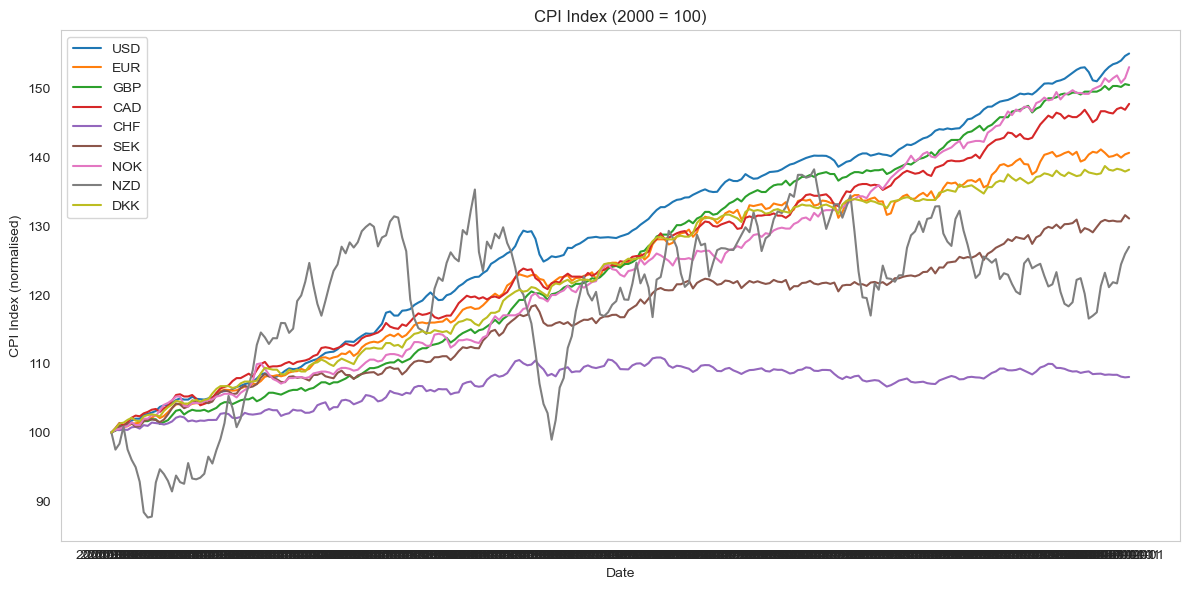

In [73]:
cpi_normalised = cpi_data_is / cpi_data_is.iloc[0] * 100

plt.figure(figsize=(12, 6))
for country in cpi_normalised.columns:
    plt.plot(cpi_normalised.index, cpi_normalised[country], label=country)

plt.title("CPI Index (2000 = 100)")
plt.xlabel("Date")
plt.ylabel("CPI Index (normalised)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

CPI is released with a lag, and the dates for realease are different for each country. Lag the CPI by 1 month. However, as an improvement to this strategy will be using on the dates/next day when it was released. **For now lag it by 1 months for each country**

In [74]:
cpi_lagged = cpi_normalised.shift(1)
cpi_lagged2 = cpi_normalised.shift(2)
fx_lagged = fx_data_is.shift(1)
cpi_lagged.drop(cpi_lagged.head(1).index,inplace=True)

In [75]:
print(cpi_lagged)
print(fx_data_is.head())

                   USD         EUR         GBP         CAD         CHF  \
Unnamed: 0                                                               
2000-02-01  100.000000  100.000000  100.000000  100.000000  100.000000   
2000-03-01  100.413467  100.320598  100.275482  100.641713  100.375801   
2000-04-01  101.004135  100.681272  100.550964  101.390379  100.341555   
2000-05-01  100.945068  100.788138  100.964187  101.069522  100.429272   
2000-06-01  101.122268  100.908362  101.239669  101.497331  100.379907   
...                ...         ...         ...         ...         ...   
2020-09-01  153.169522  140.101523  149.862259  146.523999  108.436143   
2020-10-01  153.571766  140.208389  150.413223  146.417060  108.389699   
2020-11-01  153.761961  140.462196  150.413223  147.058828  108.396380   
2020-12-01  154.111636  139.994657  150.275482  147.272705  108.127412   
2021-01-01  154.781453  140.462196  150.688705  146.951889  108.019113   

                   SEK         NOK   

**Align Data**

In [76]:
common_dates = cpi_lagged.index.intersection(fx_data.index)
cpi_lagged = cpi_lagged.loc[common_dates]
fx_monthly = fx_data_is.loc[common_dates]
vix = vix.loc['1999-11-30':]
print(vix)

             OPEN   HIGH    LOW  CLOSE
DATE                                  
1999-11-30  23.81  24.21  22.86  24.18
1999-12-01  23.41  23.41  22.23  22.23
1999-12-02  21.69  22.29  21.67  21.77
1999-12-03  19.74  19.82  18.69  19.32
1999-12-06  21.12  21.47  20.21  20.58
...           ...    ...    ...    ...
2025-04-07  60.13  60.13  38.58  46.98
2025-04-08  44.04  57.52  36.48  52.33
2025-04-09  50.98  57.96  31.90  33.62
2025-04-10  34.44  54.87  34.44  40.72
2025-04-11  40.80  46.12  36.85  37.56

[6403 rows x 4 columns]


In [77]:
print(cpi_lagged.head())
print(fx_monthly.head())

                   USD         EUR         GBP         CAD         CHF  \
Unnamed: 0                                                               
2000-02-01  100.000000  100.000000  100.000000  100.000000  100.000000   
2000-03-01  100.413467  100.320598  100.275482  100.641713  100.375801   
2000-04-01  101.004135  100.681272  100.550964  101.390379  100.341555   
2000-05-01  100.945068  100.788138  100.964187  101.069522  100.429272   
2000-06-01  101.122268  100.908362  101.239669  101.497331  100.379907   

                   SEK         NOK         NZD         DKK  
Unnamed: 0                                                  
2000-02-01  100.000000  100.000000  100.000000  100.000000  
2000-03-01  100.473203  100.402685   97.509718  100.610383  
2000-04-01  100.954160  100.536913   98.367348  101.322491  
2000-05-01  100.864952  100.805369  100.860972  101.424217  
2000-06-01  101.345909  100.939597   97.528147  101.831135  
             USD/EUR  USD/CAD   USD/GBP  USD/CHF  USD/

## Correlation HeatMap

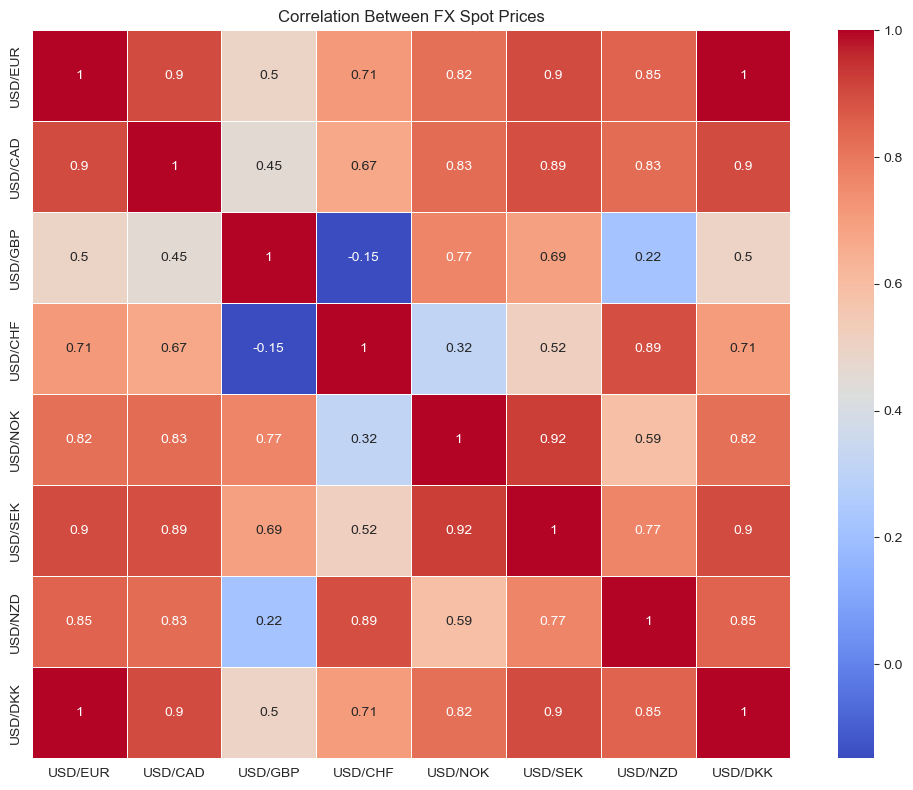

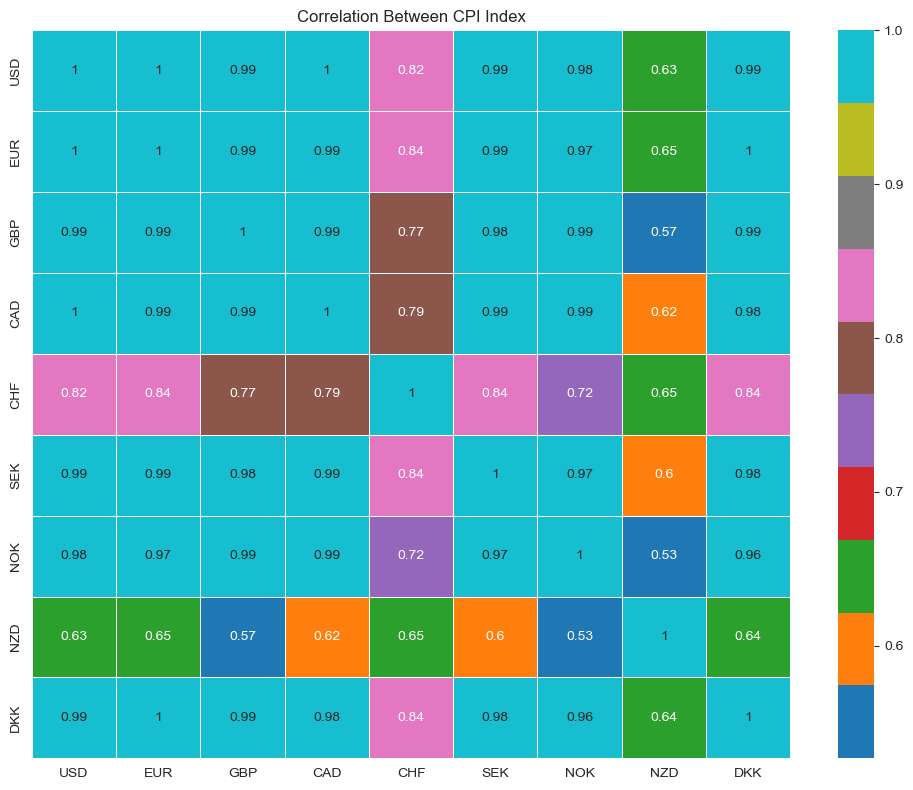

In [78]:
corr_fx = fx_monthly.corr()
corr_cpi = cpi_lagged.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_fx, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Between FX Spot Prices")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_cpi, annot=True, cmap='tab10', linewidths=0.5)
plt.title("Correlation Between CPI Index")
plt.tight_layout()
plt.show()

## Signal generation function

In [79]:
def signal_generate(fx_monthly,fx_lagged,cpi_lagged,cpi_lagged2):
    signals = pd.DataFrame(index=fx_monthly.index)

    for pair in fx_monthly.columns:
        base_currency = pair.split('/')[1]
    
        if base_currency in cpi_lagged.columns and 'USD' in cpi_lagged.columns:
            try:
                fair_fx = (cpi_lagged[base_currency]/cpi_lagged2[base_currency]) / (cpi_lagged['USD']/cpi_lagged2['USD']) * (fx_lagged[pair])
                actual_fx = fx_monthly[pair]
                misvaluation = (actual_fx-fair_fx)/actual_fx
    
                signals[pair] = -misvaluation
            except Exception as e:
                print(f"Error for {pair}: {e}")
    return signals


In [80]:
signals = signal_generate(fx_monthly,fx_lagged,cpi_lagged,cpi_lagged2)
signals.index.name = None
signals.index = pd.to_datetime(signals.index)
signals.index = signals.index.to_period("M")
signals

,USD/EUR,USD/CAD,USD/GBP,USD/CHF,USD/NOK,USD/SEK,USD/NZD,USD/DKK
2000-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-03,-0.020329,-0.004314,-0.013919,-0.017680,-0.020628,-0.005054,-0.029116,-0.017539
2000-04,-0.022346,-0.003975,-0.001602,-0.007440,-0.029581,-0.006969,0.014762,-0.019680
2000-05,-0.039695,-0.020453,-0.041845,-0.029592,-0.043962,-0.038110,-0.026175,-0.040467
2000-06,0.048644,0.015165,0.001104,0.044546,0.042482,0.042614,-0.035353,0.051126
...,...,...,...,...,...,...,...,...
2020-09,-0.011737,-0.005246,-0.022170,-0.008726,-0.031074,-0.021494,-0.011041,-0.010865
2020-10,-0.003298,-0.002442,0.003599,-0.000315,-0.013448,0.000323,-0.000744,-0.005063
2020-11,0.005502,0.014267,0.015537,0.000360,0.022953,0.018357,0.030089,0.005063
2020-12,0.023168,0.019776,0.014642,0.020574,0.035372,0.032874,0.055790,0.026336


Plot signals

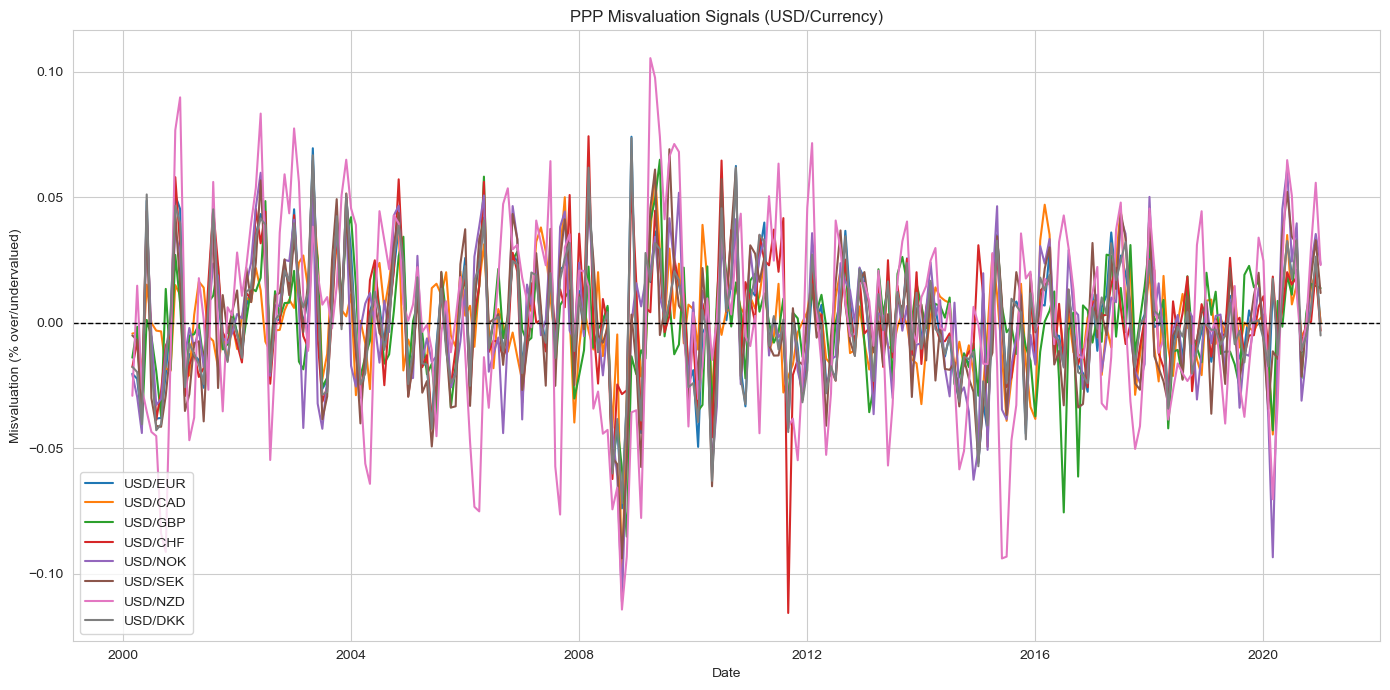

In [81]:
plt.figure(figsize=(14, 7))
for column in signals.columns:
    plt.plot(signals.index.to_timestamp(), signals[column], label=column)

plt.axhline(0, color='black', linewidth=1, linestyle='--')
plt.title('PPP Misvaluation Signals (USD/Currency)')
plt.xlabel('Date')
plt.ylabel('Misvaluation (% over/undervalued)')
plt.legend()
plt.tight_layout()
plt.show()

## Signal Summary

In [82]:
summary_stats = signals.describe().T[['mean', 'std', 'min', 'max']]
summary_stats['% of time overvalued'] = (signals > 0).mean() * 100
summary_stats['% of time undervalued'] = (signals < 0).mean() * 100

print(summary_stats.round(3))

          mean    std    min    max  % of time overvalued  \
USD/EUR  0.001  0.023 -0.074  0.074                50.000   
USD/CAD  0.001  0.019 -0.107  0.060                50.397   
USD/GBP -0.001  0.021 -0.085  0.065                50.794   
USD/CHF  0.001  0.023 -0.116  0.074                49.206   
USD/NOK  0.000  0.027 -0.111  0.062                50.000   
USD/SEK -0.000  0.026 -0.094  0.069                47.619   
USD/NZD  0.001  0.038 -0.114  0.105                52.381   
USD/DKK  0.001  0.023 -0.072  0.074                49.603   

         % of time undervalued  
USD/EUR                 49.603  
USD/CAD                 49.206  
USD/GBP                 48.810  
USD/CHF                 50.397  
USD/NOK                 49.603  
USD/SEK                 51.984  
USD/NZD                 47.222  
USD/DKK                 50.000  


Start calculating the returns

In [83]:
fx_returns = fx_monthly.pct_change().shift(-1)

In [84]:
fx_returns.index.name = None
fx_returns.index = pd.to_datetime(fx_returns.index)
fx_returns.index = fx_returns.index.to_period("M")

In [85]:
positions = -signals  # go long undervalued, short overvalued

In [86]:
# calculate excess fx returns
pairs = full_df.columns.levels[0]  
new_data = {}
for pair in pairs:
    spot_col = (pair, "spot USD base")
    fwd_col  = (pair, "fwd USD base")

    roll_list = []

    for i in range(len(full_df)):
        if i == len(full_df)-1:
            roll_list.append(np.nan)
        else:
            fwd_tmr = full_df.iloc[i+1][fwd_col]
            fwd_today = full_df.iloc[i][fwd_col]
            # spot_today = full_df.iloc[i][spot_col]
            # fwd_yesterday = full_df.iloc[i-1][fwd_col]
            # spot_yesterday = full_df.iloc[i-1][spot_col]
            val2 = (fwd_tmr - fwd_today) / fwd_today
            # val = (fwd_today - fwd_yesterday) / fwd_yesterday
            roll_list.append(val2)

    new_data[pair] = roll_list

excess_fx_returns = pd.DataFrame(new_data, index=full_df.index)
excess_fx_returns = excess_fx_returns[["USD/EUR", "USD/CAD", "USD/GBP", "USD/CHF", "USD/NOK", "USD/SEK", "USD/NZD", "USD/DKK"]]
excess_fx_returns = excess_fx_returns.loc[positions.index]

In [87]:
print(excess_fx_returns)

          USD/EUR   USD/CAD   USD/GBP   USD/CHF   USD/NOK   USD/SEK   USD/NZD  \
2000-02  0.019858  0.012688  0.000316  0.006565  0.017735  0.020003  0.020994   
2000-03  0.020614 -0.001728 -0.011590  0.005563  0.001643  0.021247  0.025676   
2000-04  0.043017  0.048537  0.053694  0.018217  0.031961  0.043809  0.049672   
2000-05 -0.046785 -0.000460  0.000584 -0.012505 -0.045192 -0.046509 -0.041494   
2000-06  0.012568  0.000945  0.023491  0.000481  0.006297  0.012688  0.004610   
...           ...       ...       ...       ...       ...       ...       ...   
2020-09  0.001533 -0.002477  0.004010 -0.000924 -0.002646  0.001603  0.014758   
2020-10 -0.004957 -0.016577 -0.031837 -0.010988 -0.001598 -0.004601 -0.020832   
2020-11 -0.028528 -0.017956 -0.033461 -0.020356 -0.025278 -0.029175 -0.043595   
2020-12 -0.000435 -0.014815 -0.014971 -0.006394 -0.001713 -0.000787 -0.022407   
2021-01  0.007084 -0.016183 -0.005997 -0.002254  0.013055  0.006850 -0.000162   

          USD/DKK  
2000-02

In [88]:
print(positions.index)
print(excess_fx_returns.index)

PeriodIndex(['2000-02', '2000-03', '2000-04', '2000-05', '2000-06', '2000-07',
             '2000-08', '2000-09', '2000-10', '2000-11',
             ...
             '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09',
             '2020-10', '2020-11', '2020-12', '2021-01'],
            dtype='period[M]', length=252)
PeriodIndex(['2000-02', '2000-03', '2000-04', '2000-05', '2000-06', '2000-07',
             '2000-08', '2000-09', '2000-10', '2000-11',
             ...
             '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09',
             '2020-10', '2020-11', '2020-12', '2021-01'],
            dtype='period[M]', length=252)


In [89]:
strategy_returns_per_pair = (positions * fx_returns)
strategy_returns_per_pair_excess = (positions * excess_fx_returns)
strategy_returns = strategy_returns_per_pair.mean(axis=1)
strategy_returns_excess = strategy_returns_per_pair_excess.mean(axis=1)
print(strategy_returns_per_pair)
print(strategy_returns_per_pair_excess)

          USD/EUR   USD/CAD   USD/GBP       USD/CHF   USD/NOK   USD/SEK  \
2000-02       NaN       NaN       NaN           NaN       NaN       NaN   
2000-03  0.000417  0.000024 -0.000021  2.231846e-05  0.000533  0.000030   
2000-04  0.000962  0.000073  0.000078  2.380714e-04  0.001461  0.000274   
2000-05 -0.001863 -0.000256 -0.000006 -1.325521e-03 -0.001809 -0.001448   
2000-06 -0.000617 -0.000008 -0.000001 -2.685772e-04 -0.000185 -0.001057   
...           ...       ...       ...           ...       ...       ...   
2020-09  0.000017 -0.000005 -0.000056 -2.384370e-05  0.000453 -0.000050   
2020-10 -0.000016 -0.000027  0.000059 -4.829903e-07 -0.000283  0.000006   
2020-11  0.000155  0.000288  0.000273  8.920575e-06  0.000991  0.000623   
2020-12  0.000019  0.000130  0.000222  4.400029e-05  0.000802  0.000300   
2021-01       NaN       NaN       NaN           NaN       NaN       NaN   

          USD/NZD   USD/DKK  
2000-02       NaN       NaN  
2000-03 -0.000340  0.000373  
2000-04 -

2000-03    0.000130
2000-04    0.000395
2000-05   -0.001071
2000-06   -0.000242
2000-07    0.000512
             ...   
2020-08   -0.000272
2020-09    0.000049
2020-10   -0.000038
2020-11    0.000436
2020-12    0.000297
Freq: M, Length: 250, dtype: float64


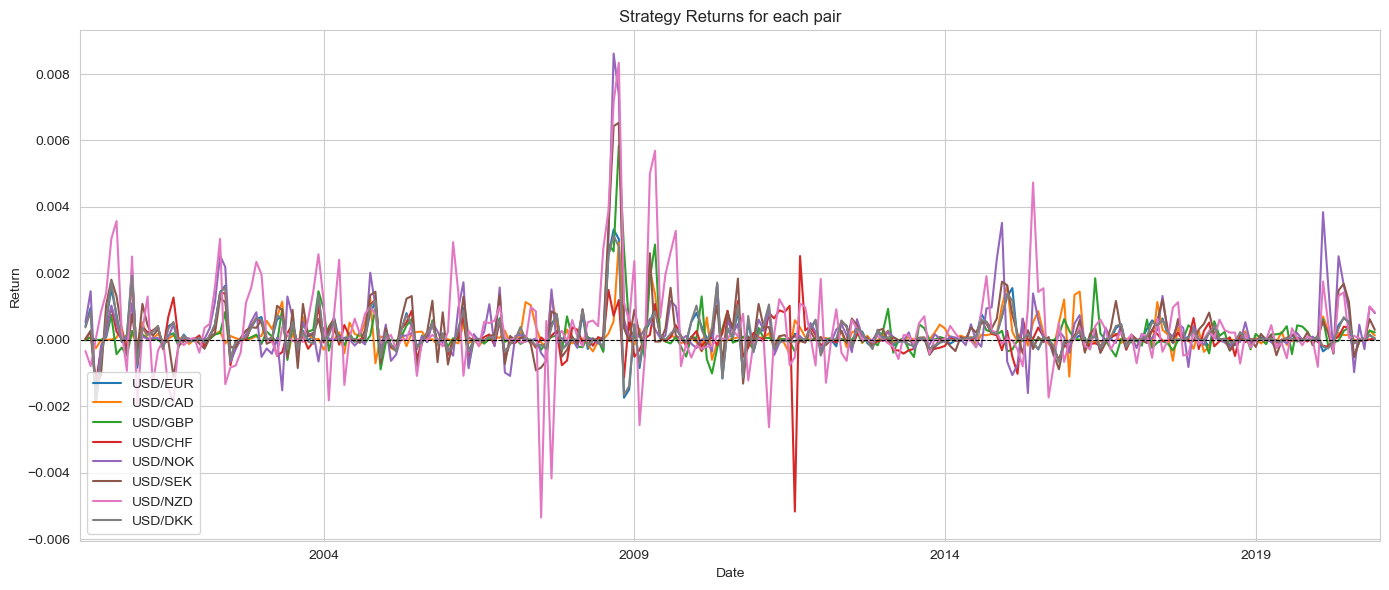

2000-03    0.000167
2000-04    0.000333
2000-05   -0.001076
2000-06   -0.000323
2000-07    0.000474
             ...   
2020-09    0.000022
2020-10   -0.000010
2020-11    0.000443
2020-12    0.000277
2021-01   -0.000034
Freq: M, Length: 251, dtype: float64


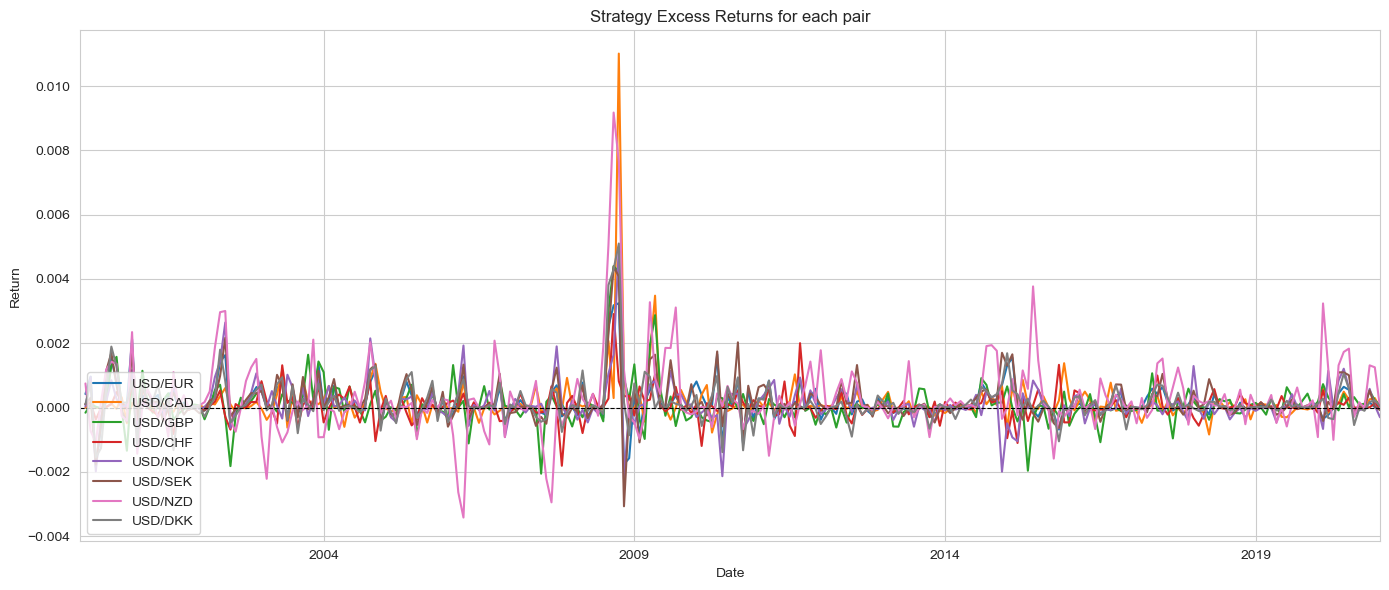

In [90]:
strategy_returns.dropna(inplace=True)
print(strategy_returns)

plt.figure(figsize=(14, 6))
strategy_returns_per_pair.plot(ax=plt.gca())
plt.title("Strategy Returns for each pair")
plt.ylabel("Return")
plt.xlabel("Date")
plt.legend(loc='lower left')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()

strategy_returns_excess.dropna(inplace=True)
print(strategy_returns_excess)

plt.figure(figsize=(14, 6))
strategy_returns_per_pair_excess.plot(ax=plt.gca())
plt.title("Strategy Excess Returns for each pair")
plt.ylabel("Return")
plt.xlabel("Date")
plt.legend(loc='lower left')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()

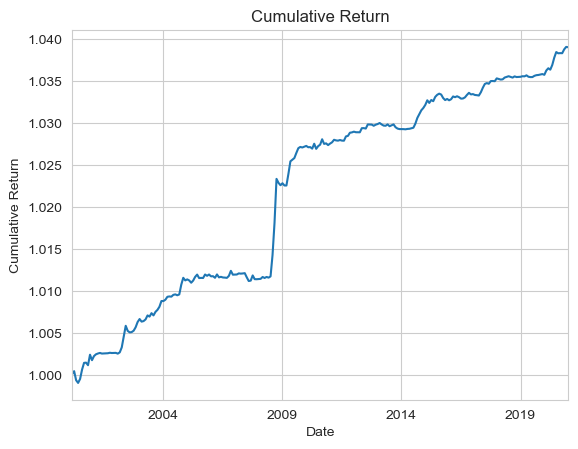

{'portfolio_cum_returns': 1.0390600006735866, 'ann_return': 0.0018352681423787764, 'ann_vol': 0.0018622427794686824, 'sharpe': -4.384354149543653, 'max_drawdown(%)': -0.13983395772428908}


In [91]:
stats_excess = aqms.evaluate_strategy(strategy_returns_excess)
print(stats_excess)

**Calculate Volatility of a Portfolio**

In [92]:
window = 12

# Assume equal weights for each pair
weights = np.repeat(1 / strategy_returns_per_pair.shape[1], strategy_returns_per_pair.shape[1])

# Calculate rolling covariance matrices (monthly returns assumed)
rolling_cov = strategy_returns_per_pair.rolling(window).cov(pairwise=True)

# Function to compute portfolio volatility from covariance matrix
def compute_volatility(cov_matrix, weights):
    return np.sqrt(np.dot(weights, np.dot(cov_matrix, weights)))

# Empty series to store rolling volatility
vol_series = pd.Series(index=strategy_returns_per_pair.index)

# Loop through dates to calculate rolling volatility
for date in strategy_returns_per_pair.index[window-1:]:
    # Extract rolling covariance matrix for the current date
    cov = rolling_cov.loc[date]
    if isinstance(cov, pd.DataFrame):  # some rows may return NaN
        vol_series[date] = compute_volatility(cov, weights)

# Convert to annualised volatility if needed
vol_series_annualised = vol_series * np.sqrt(12)
print(vol_series_annualised)

2000-02         NaN
2000-03         NaN
2000-04         NaN
2000-05         NaN
2000-06         NaN
             ...   
2020-09    0.001417
2020-10    0.001428
2020-11    0.001429
2020-12    0.001400
2021-01         NaN
Freq: M, Length: 252, dtype: float64


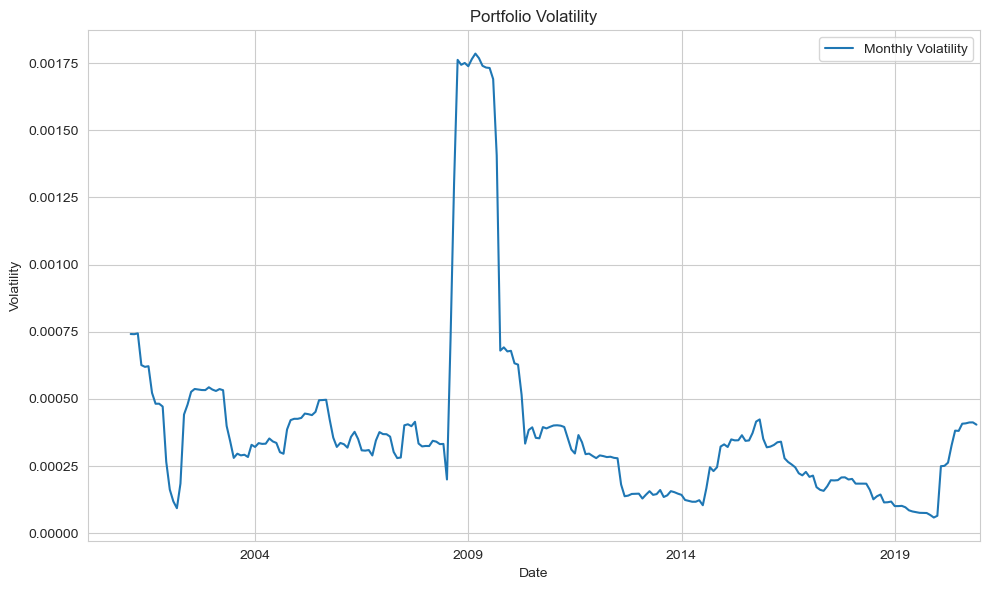

In [93]:
plt.figure(figsize=(10, 6))
vol_series.plot(label="Monthly Volatility")
plt.title("Portfolio Volatility")
plt.ylabel("Volatility")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

In [94]:
window = 12

# Assume equal weights for each pair
weights_excess = np.repeat(1 / strategy_returns_per_pair_excess.shape[1], strategy_returns_per_pair_excess.shape[1])

# Calculate rolling covariance matrices (monthly returns assumed)
rolling_cov_excess = strategy_returns_per_pair_excess.rolling(window).cov(pairwise=True)

# Function to compute portfolio volatility from covariance matrix
def compute_volatility_excess(cov_matrix_excess, weights_excess):
    return np.sqrt(np.dot(weights_excess, np.dot(cov_matrix_excess, weights_excess)))

# Empty series to store rolling volatility
vol_series_excess = pd.Series(index=strategy_returns_per_pair_excess.index)

# Loop through dates to calculate rolling volatility
for date in strategy_returns_per_pair_excess.index[window-1:]:
    # Extract rolling covariance matrix for the current date
    cov_excess = rolling_cov_excess.loc[date]
    if isinstance(cov_excess, pd.DataFrame):  # some rows may return NaN
        vol_series_excess[date] = compute_volatility_excess(cov_excess, weights_excess)

# Convert to annualised volatility if needed
vol_series_annualised_excess = vol_series_excess * np.sqrt(12)
print(vol_series_annualised_excess)

2000-02         NaN
2000-03         NaN
2000-04         NaN
2000-05         NaN
2000-06         NaN
             ...   
2020-09    0.001167
2020-10    0.001174
2020-11    0.001183
2020-12    0.001164
2021-01    0.001148
Freq: M, Length: 252, dtype: float64


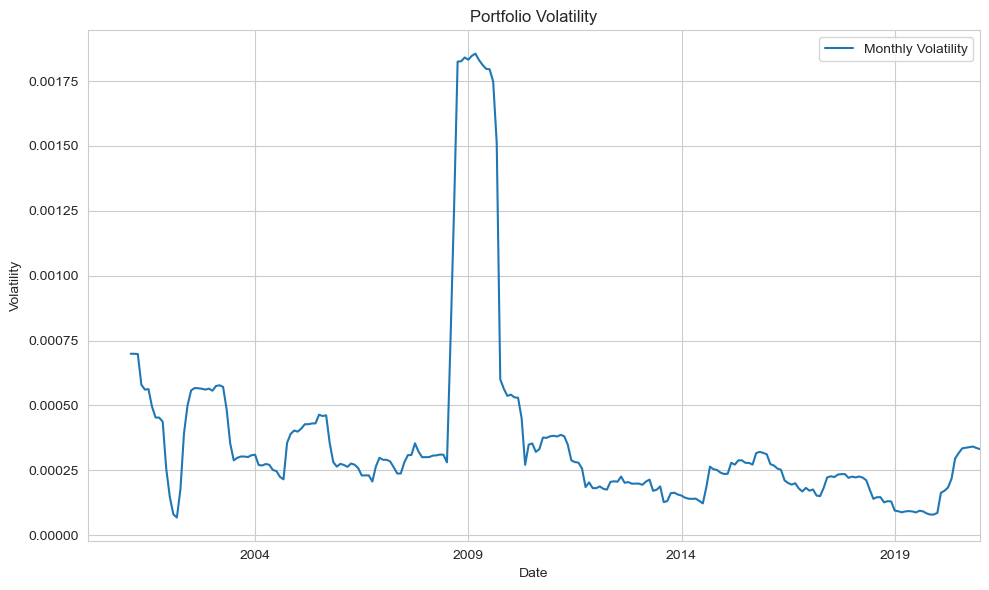

In [95]:
plt.figure(figsize=(10, 6))
vol_series_excess.plot(label="Monthly Volatility")
plt.title("Portfolio Volatility")
plt.ylabel("Volatility")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

## Normalise portfolio to hit a constant 1% volatility target

## FWD returns 

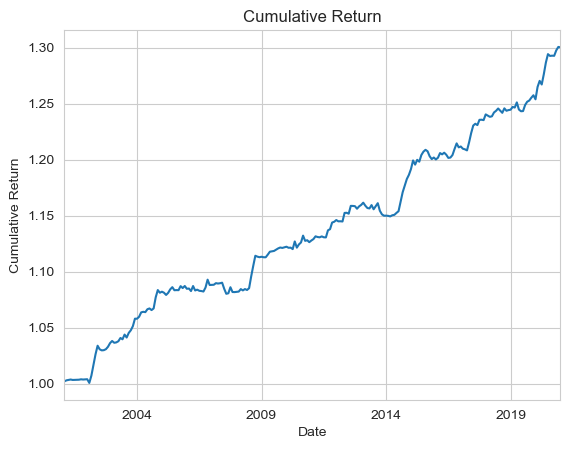

{'portfolio_cum_returns': 1.3003598113877368, 'ann_return': 0.013271434480800037, 'ann_vol': 0.010246398710134736, 'sharpe': 0.3192765159103416, 'max_drawdown(%)': -1.1536605916344533}


In [96]:
rolling_vol_excess = strategy_returns_excess.rolling(window=12).std()
target_vol_monthly = 0.01 / (12 ** 0.5)
scale_factor = target_vol_monthly / rolling_vol_excess
positions_scaled = -signals.mul(scale_factor, axis=0)
strategy_returns_scaled_excess = (positions_scaled * excess_fx_returns).mean(axis=1).dropna()
stats_normalised = aqms.evaluate_strategy(strategy_returns_scaled_excess)
print(stats_normalised)

## Parameter Sensitivity to improve results

I will test the results using various threshold for signal generation, momentum filters to avoid taking positions on the signals that driven by momentum or small mispricing to the values. The understanding of the right momentum and avoidance of data leakages is arguably the most important to assess the reliability of the reults, hence lead/lag analysis is done on filtered signals. Furthermore, this section also includes the analysis of features, i.e I performed Jackknife Test to better understand if there is any significant anti-/pro-contributor currency pair to the signal. 

In [97]:
def signal_generate_with_threshold(fx_monthly, fx_lagged, cpi_lagged, cpi_lagged2, threshold=None):
    signals = pd.DataFrame(index=fx_monthly.index)

    for pair in fx_monthly.columns:
        base_currency = pair.split('/')[1]

        if base_currency in cpi_lagged.columns and 'USD' in cpi_lagged.columns:
            try:
                fair_fx = (
                    (cpi_lagged[base_currency] / cpi_lagged2[base_currency]) /
                    (cpi_lagged['USD'] / cpi_lagged2['USD'])
                ) * fx_lagged[pair]

                actual_fx = fx_monthly[pair]
                misvaluation = (actual_fx - fair_fx) / actual_fx

                if threshold is not None:
                    misvaluation = misvaluation.where(abs(misvaluation) > threshold, 0)

                signals[pair] = -misvaluation
            except Exception as e:
                print(f"Error for {pair}: {e}")
    signals.index.name = None
    signals.index = pd.to_datetime(signals.index)
    signals.index = signals.index.to_period("M")
    return -signals
signal_threshold_no = signal_generate_with_threshold(fx_monthly,fx_lagged,cpi_lagged,cpi_lagged2, 0) 
signal_threshold00 = signal_generate_with_threshold(fx_monthly,fx_lagged,cpi_lagged,cpi_lagged2, 0.005) 
signal_threshold0 = signal_generate_with_threshold(fx_monthly,fx_lagged,cpi_lagged,cpi_lagged2, 0.1) 
signal_threshold1 = signal_generate_with_threshold(fx_monthly,fx_lagged,cpi_lagged,cpi_lagged2, 0.0015) 
signal_threshold2 = signal_generate_with_threshold(fx_monthly,fx_lagged,cpi_lagged,cpi_lagged2, 0.01)
signal_threshold3 = signal_generate_with_threshold(fx_monthly,fx_lagged,cpi_lagged,cpi_lagged2, 0.015) 
signal_threshold4 = signal_generate_with_threshold(fx_monthly,fx_lagged,cpi_lagged,cpi_lagged2, 0.0001) 

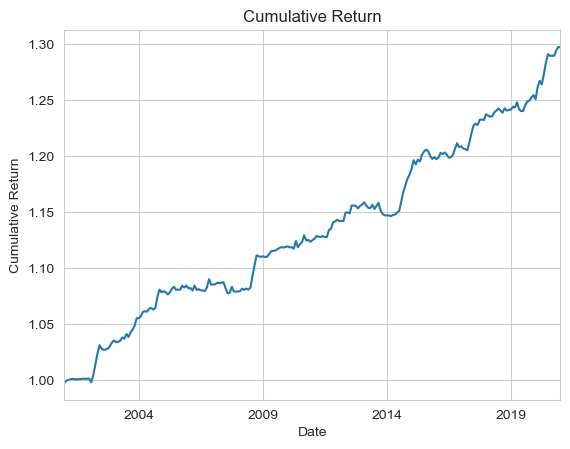

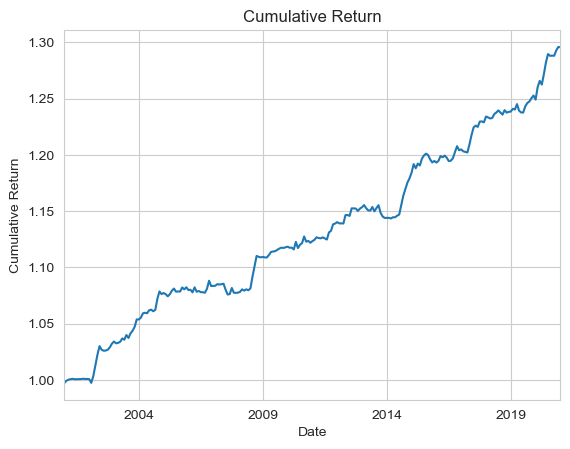

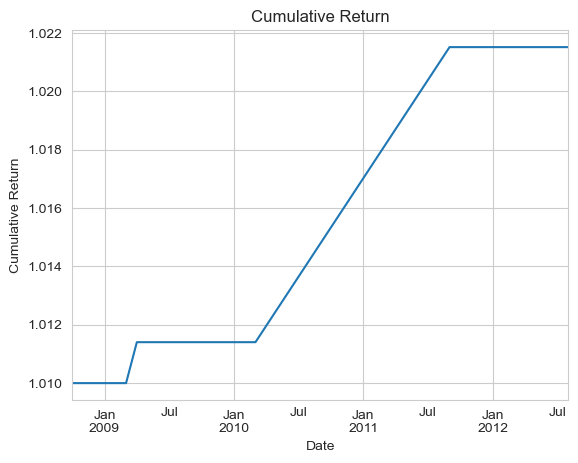

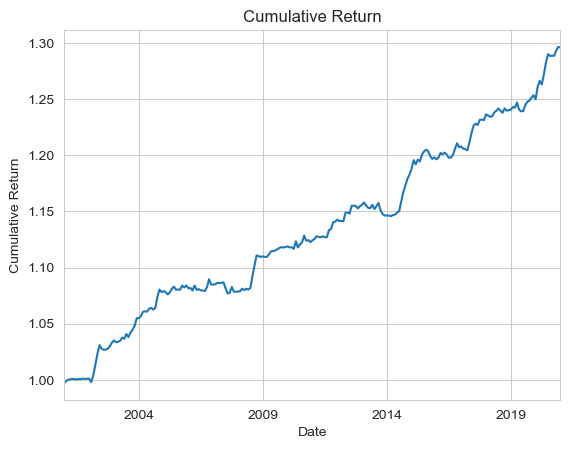

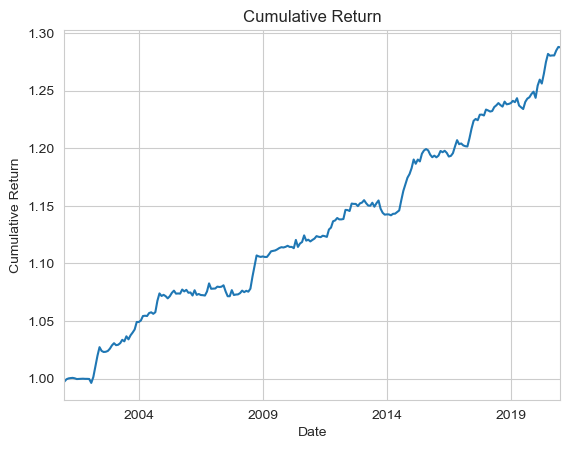

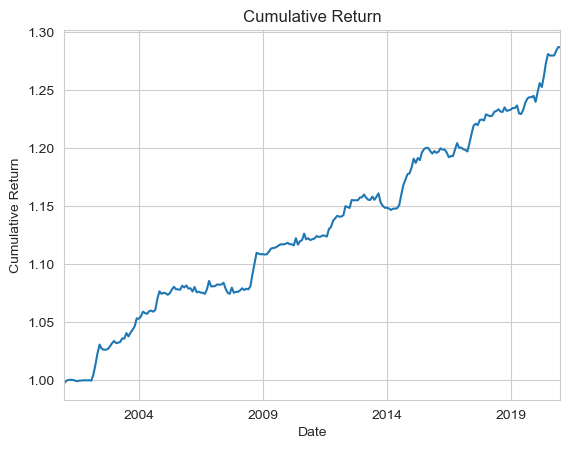

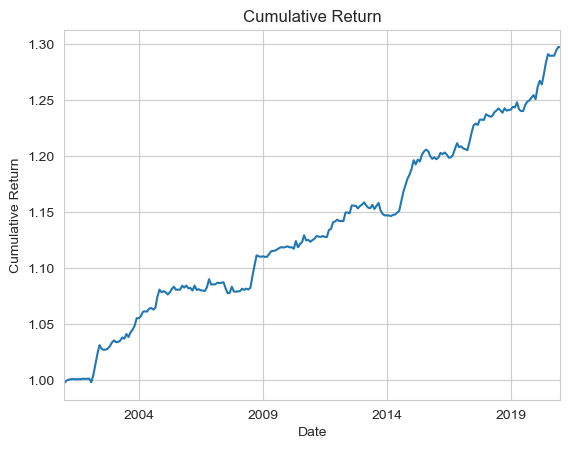

                  portfolio_cum_returns  ann_return   ann_vol    sharpe  \
no_threshold                   1.296851    0.013080  0.010260  0.300197   
threshold_0.005                1.295501    0.013027  0.010233  0.295820   
threshold_0.01                 1.021518    0.008589  0.008789 -0.160487   
threshold_0.02                 1.296164    0.013053  0.010259  0.297611   
threshold_0.03                 1.287642    0.012720  0.010225  0.266051   
threshold_0.001                1.287009    0.012695  0.010190  0.264479   
threshold_0.0001               1.296853    0.013080  0.010260  0.300204   

                  max_drawdown(%)  
no_threshold            -1.153661  
threshold_0.005         -1.128048  
threshold_0.01           0.000000  
threshold_0.02          -1.158056  
threshold_0.03          -1.139526  
threshold_0.001         -1.233743  
threshold_0.0001        -1.153772  


In [98]:
signals_dict = {
    'no_threshold': signal_threshold_no,
    "threshold_0.005": signal_threshold00,
    "threshold_0.01": signal_threshold0,
    "threshold_0.02": signal_threshold1,
    "threshold_0.03": signal_threshold2,
    "threshold_0.001": signal_threshold3,
    "threshold_0.0001": signal_threshold4
}

target_vol_annual = 0.01
target_vol_monthly = target_vol_annual / (12 ** 0.5)

results_normalised = {}

for name, signal in signals_dict.items():
    # Step 1: Unscaled returns from signal
    raw_returns = (signal * excess_fx_returns).mean(axis=1)
    
    # Step 2: Rolling volatility
    rolling_vol = raw_returns.rolling(window=12).std()
    
    # Step 3: Scale factor
    scale_factor = target_vol_monthly / rolling_vol
    
    # Step 4: Apply scale to signal
    signal_scaled = signal.mul(scale_factor, axis=0)
    
    # Step 5: Strategy returns
    strategy_returns_scaled = (signal_scaled * excess_fx_returns).mean(axis=1).dropna()
    
    # Step 6: Evaluate strategy
    # print(fx_returns)
    stats_normalised = aqms.evaluate_strategy(strategy_returns_scaled)
    results_normalised[name] = stats_normalised

# Convert to DataFrame for display
import pandas as pd

results_df = pd.DataFrame(results_normalised).T  # Transpose to have thresholds as rows
print(results_df)

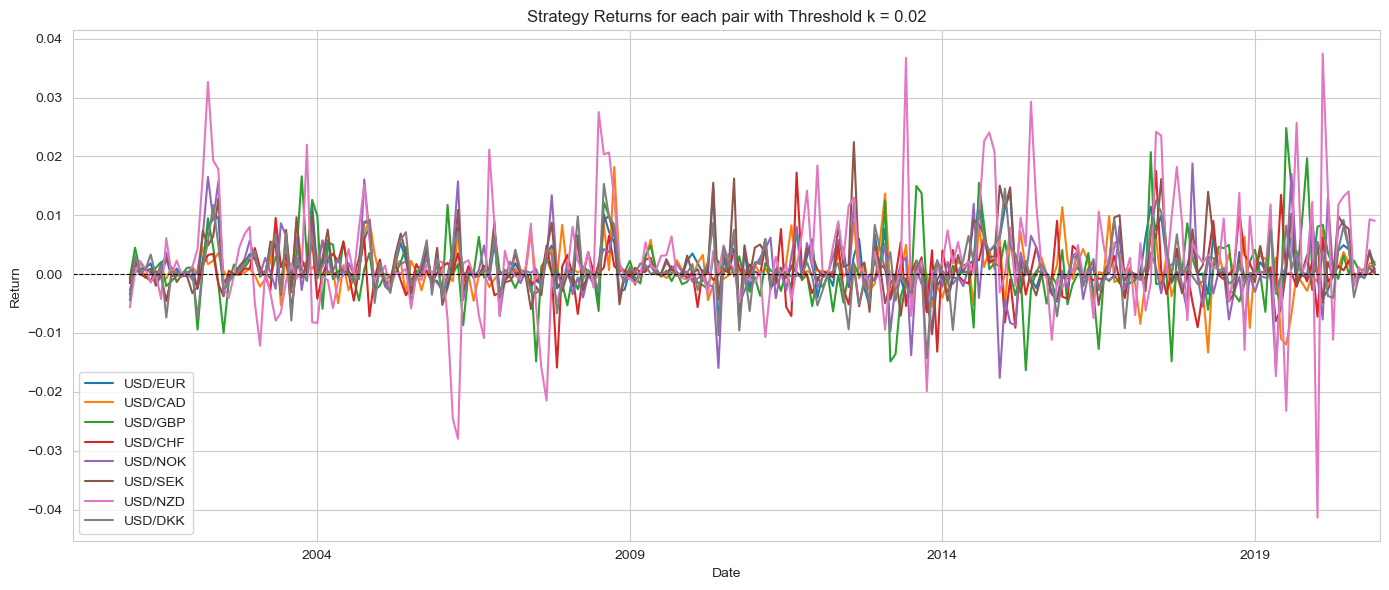

In [99]:

raw_returns = (signal_threshold2 * fx_returns).mean(axis=1)
    
    # Step 2: Rolling volatility
rolling_vol = raw_returns.rolling(window=12).std()
    
    # Step 3: Scale factor
scale_factor = target_vol_monthly / rolling_vol
    
    # Step 4: Apply scale to signal
signal_scaled = signal.mul(scale_factor, axis=0)
    
    # Step 5: Strategy returns
strategy_returns_per_pair_threshold = (signal_scaled * excess_fx_returns)
plt.figure(figsize=(14, 6))
strategy_returns_per_pair_threshold.plot(ax=plt.gca())
plt.title("Strategy Returns for each pair with Threshold k = 0.02")
plt.ylabel("Return")
plt.xlabel("Date")
plt.legend(loc='lower left')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()

## Momentum filter

In [100]:
fx_monthly.index = pd.to_datetime(fx_monthly.index).to_period('M')

In [101]:
print(positions_scaled.index)
print(fx_monthly.index)
print(excess_fx_returns.index)

PeriodIndex(['2000-02', '2000-03', '2000-04', '2000-05', '2000-06', '2000-07',
             '2000-08', '2000-09', '2000-10', '2000-11',
             ...
             '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09',
             '2020-10', '2020-11', '2020-12', '2021-01'],
            dtype='period[M]', length=252)
PeriodIndex(['2000-02', '2000-03', '2000-04', '2000-05', '2000-06', '2000-07',
             '2000-08', '2000-09', '2000-10', '2000-11',
             ...
             '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09',
             '2020-10', '2020-11', '2020-12', '2021-01'],
            dtype='period[M]', length=252)
PeriodIndex(['2000-02', '2000-03', '2000-04', '2000-05', '2000-06', '2000-07',
             '2000-08', '2000-09', '2000-10', '2000-11',
             ...
             '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09',
             '2020-10', '2020-11', '2020-12', '2021-01'],
            dtype='period[M]', length=252)


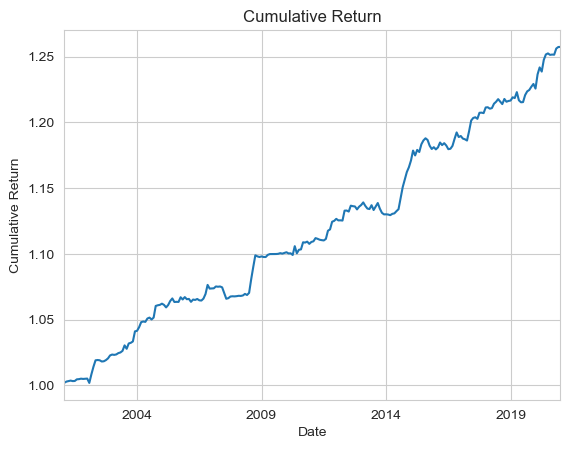

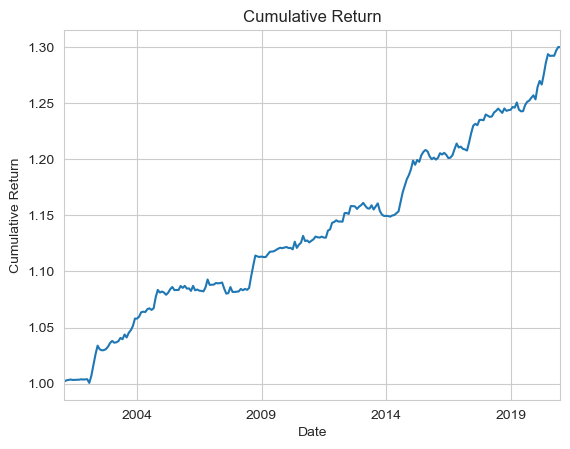

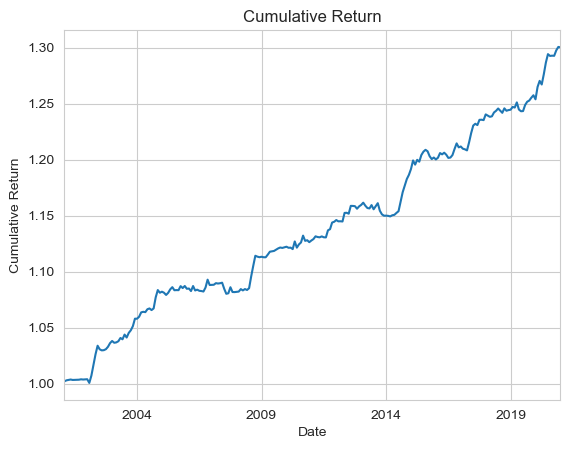

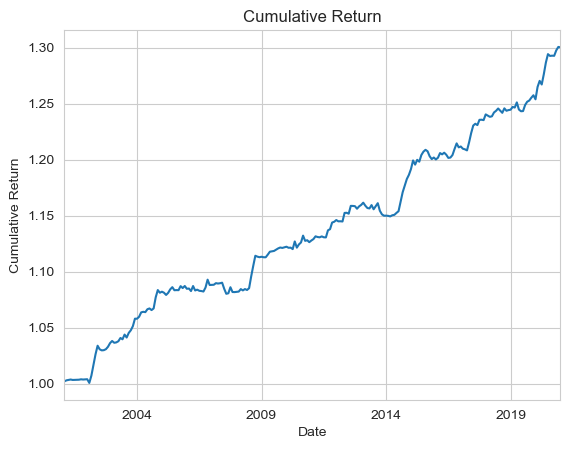

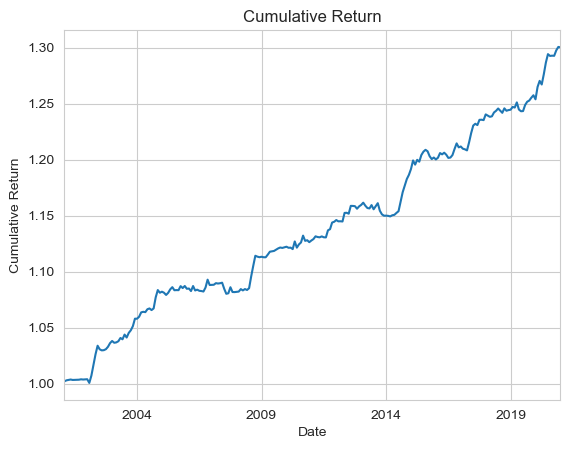

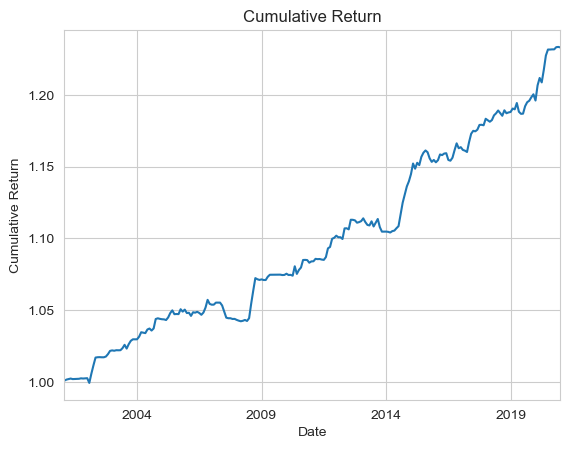

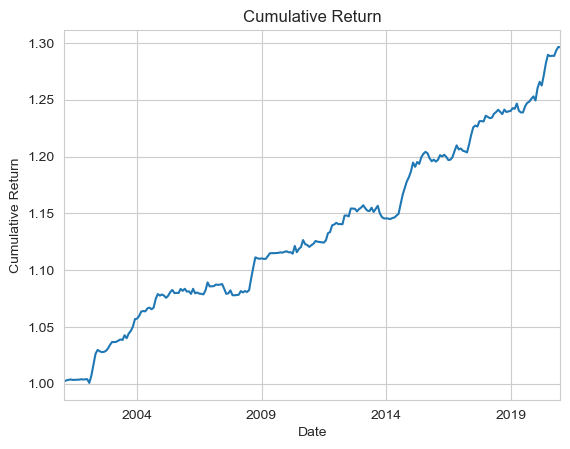

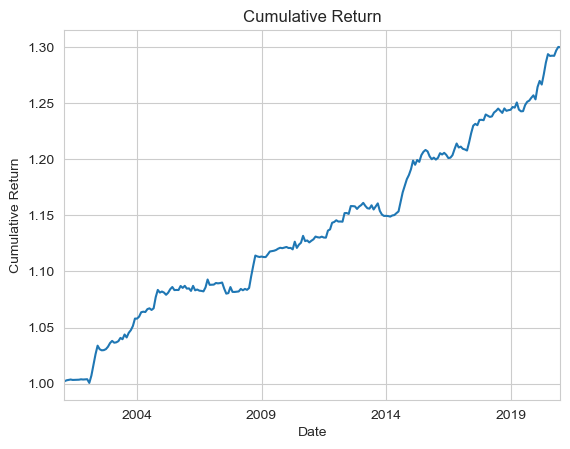

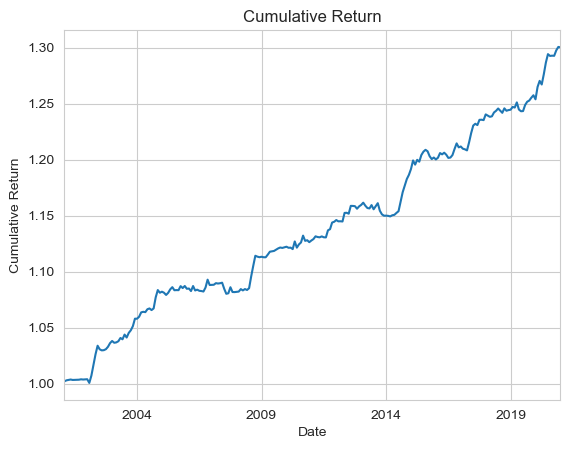

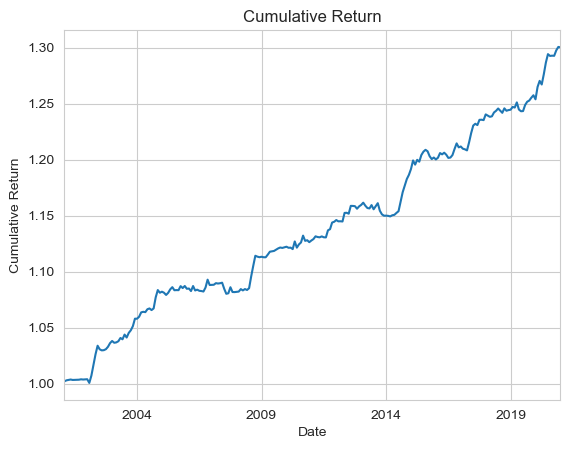

   portfolio_cum_returns  ann_return   ann_vol    sharpe  max_drawdown(%)  \
2               1.300360    0.013271  0.010246  0.319277        -1.153661   
3               1.300360    0.013271  0.010246  0.319277        -1.153661   
4               1.300360    0.013271  0.010246  0.319277        -1.153661   
8               1.300360    0.013271  0.010246  0.319277        -1.153661   
9               1.300360    0.013271  0.010246  0.319277        -1.153661   
1               1.299859    0.013252  0.010246  0.317377        -1.153661   
7               1.299864    0.013252  0.010247  0.317374        -1.153661   
6               1.296157    0.013104  0.009873  0.314348        -1.056927   
0               1.257474    0.011561  0.008962  0.174232        -0.978638   
5               1.232982    0.010567  0.008931  0.063462        -1.410739   

   momentum_window  threshold  
2                3      -0.20  
3                3      -0.30  
4                3      -0.40  
8                6      

In [102]:

results = []

# Define momentum windows (in months) and thresholds
momentum_windows = [3, 6]
thresholds = [-0.05, -0.1, -0.2, -0.3, -0.4]

for window in momentum_windows:
    # Calculate momentum (e.g., past 3-month return = pct_change(n-1))
    momentum = fx_monthly.pct_change(window - 1)

    for threshold in thresholds:
        # Create the filter
        momentum_filter = (momentum > threshold)

        # Align and forward-fill to match signal index
        aligned_filter = momentum_filter.reindex(positions_scaled.index).ffill()

        # Apply filter
        signals_filtered = positions_scaled * aligned_filter.astype(float)

        # Strategy returns
        strategy_returns = (signals_filtered * excess_fx_returns).mean(axis=1).dropna()

        # Evaluate
        stats = aqms.evaluate_strategy(strategy_returns)

        # Add identifying info
        stats['momentum_window'] = window
        stats['threshold'] = threshold
        results.append(stats)

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Optional: sort by Sharpe ratio or another metric
results_df = results_df.sort_values(by='sharpe', ascending=False)

print(results_df.round(7))



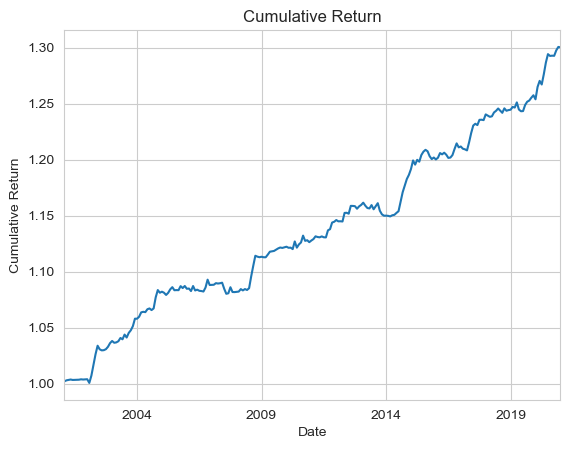

{'portfolio_cum_returns': 1.3003598113877368, 'ann_return': 0.013271434480800037, 'ann_vol': 0.010246398710134736, 'sharpe': 0.3192765159103416, 'max_drawdown(%)': -1.1536605916344533}


In [103]:
momentum = fx_monthly.pct_change(3 - 1)
momentum_filter = (momentum > -0.2)
# Align and forward-fill to match signal index
aligned_filter = momentum_filter.reindex(positions_scaled.index).ffill()
# Apply filter
signals_filtered = positions_scaled * aligned_filter.astype(float)
strategy_returns = (signals_filtered * excess_fx_returns).mean(axis=1).dropna()
# Evaluate
stats = aqms.evaluate_strategy(strategy_returns)
print(stats)

## Lead/Lag analysis
On the filtered signal from -4 months(entering position 4 months late) to +4 months, i.e. 4 months in advance.

signal is shifted by:  -4


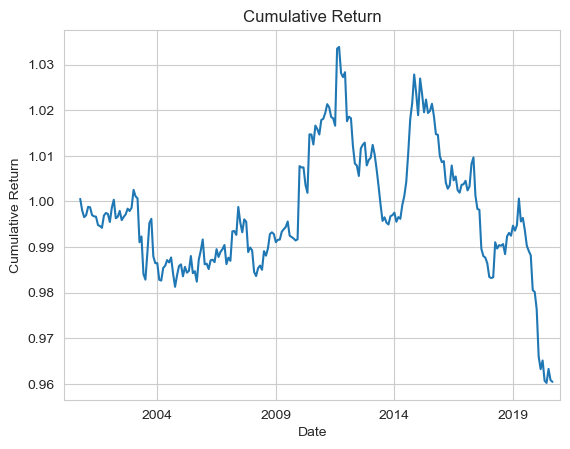

signal is shifted by:  -3


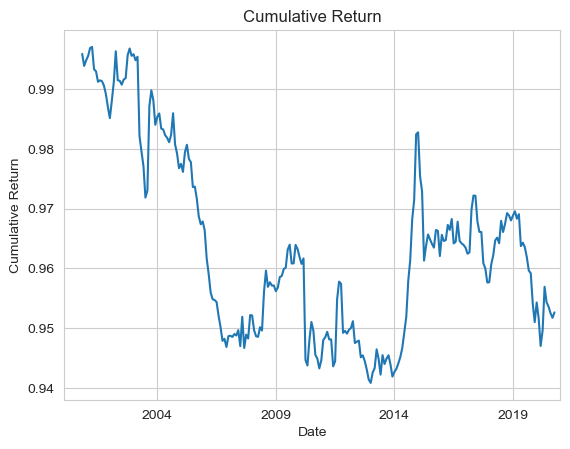

signal is shifted by:  -2


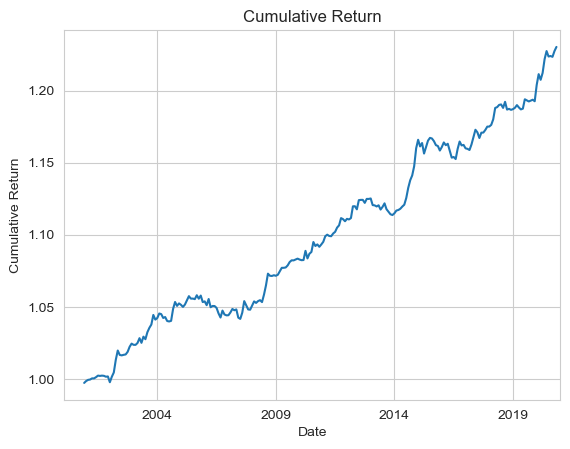

signal is shifted by:  -1


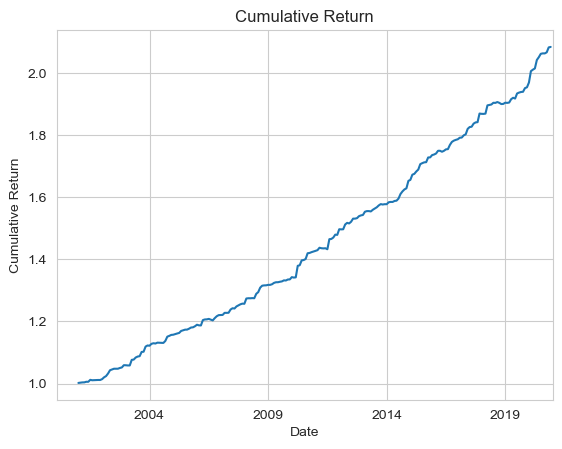

signal is shifted by:  0


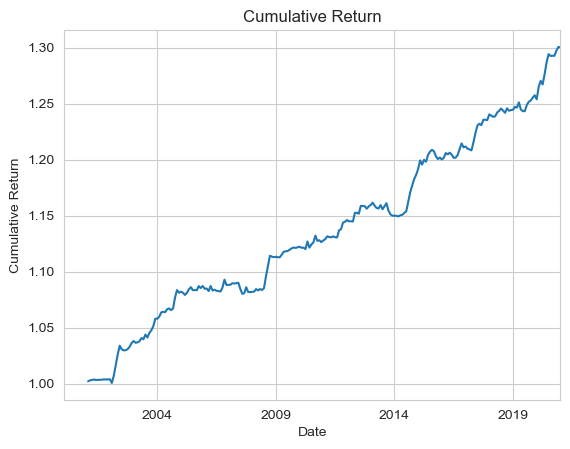

signal is shifted by:  1


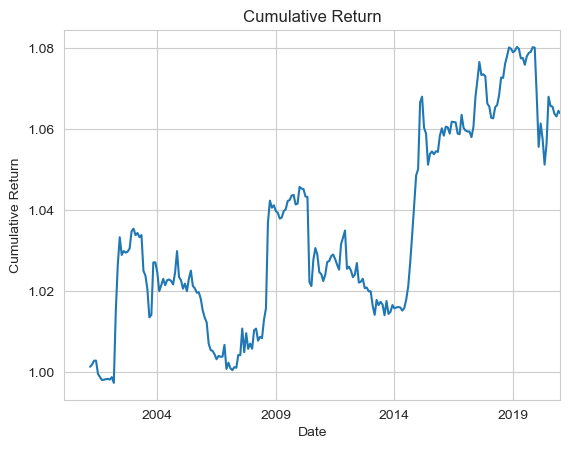

signal is shifted by:  2


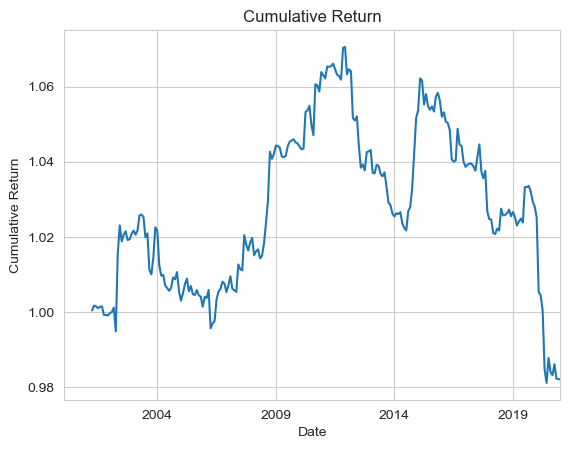

signal is shifted by:  3


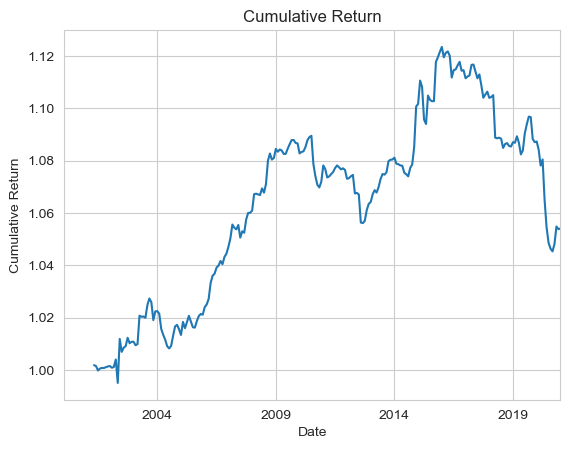

signal is shifted by:  4


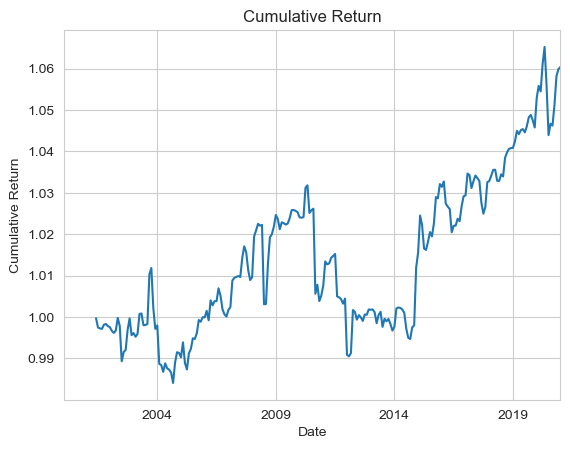

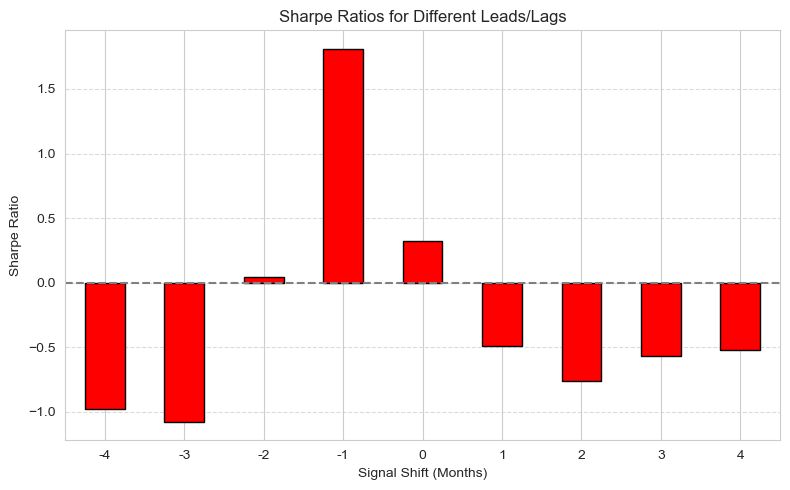

In [104]:

leads = [-4, -3, -2, -1, 0, 1, 2, 3, 4]
sharpe_ratios = {}
#strategy_returns_scaled.index = pd.to_datetime(strategy_returns_scaled.index)

for lead in leads:
    shifted_signal = signals_filtered.shift(lead)
    returns = (shifted_signal * excess_fx_returns).mean(axis=1)
    print("signal is shifted by: ", lead)
    values = aqms.evaluate_strategy(returns)
    sharpe_ratios[lead] = values['sharpe']

sharpe_df = pd.DataFrame.from_dict(sharpe_ratios, orient='index', columns=['Sharpe'])

plt.figure(figsize=(8, 5))
sharpe_df['Sharpe'].plot(kind='bar', color='red', edgecolor='black')
plt.title('Sharpe Ratios for Different Leads/Lags')
plt.xlabel('Signal Shift (Months)')
plt.ylabel('Sharpe Ratio')
plt.axhline(0, color='grey', linestyle='--')
plt.xticks(rotation=0)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## JackKnife Test Analysis

In [105]:
from collections import OrderedDict

# Calculate full strategy returns and Sharpe ratio
strategy_returns_full = (signals_filtered * excess_fx_returns).mean(axis=1)
sharpe_full = ((1+strategy_returns_full.mean())** 12 - 1) / (strategy_returns_full.std()* (12 ** 0.5))

# Dictionary to store marginal Sharpe contributions
sharpe_contributions = OrderedDict()

for currency in signals_filtered.columns:
    # Drop one currency at a time
    reduced_positions = signals_filtered.drop(columns=currency)
    reduced_returns = excess_fx_returns.drop(columns=currency)
    
    # Compute reduced strategy return
    reduced_strategy_returns = (reduced_positions * reduced_returns).mean(axis=1)
    
    # Compute Sharpe ratio
    annual_return = (1 + reduced_strategy_returns.mean()) ** 12 - 1
    annual_volatility = reduced_strategy_returns.std() * (12 ** 0.5)
    sharpe_reduced = (annual_return) / annual_volatility
    
    
    # Marginal contribution
    contribution = sharpe_full - sharpe_reduced
    sharpe_contributions[currency] = contribution

# Convert to DataFrame for easy display
import pandas as pd
sharpe_contributions_df = pd.DataFrame.from_dict(sharpe_contributions, orient='index', columns=['Sharpe Contribution'])
sharpe_contributions_df = sharpe_contributions_df.sort_values(by='Sharpe Contribution', ascending=False)

print(sharpe_contributions_df)

         Sharpe Contribution
USD/NZD             0.146738
USD/SEK             0.081939
USD/CAD             0.058091
USD/EUR             0.036409
USD/NOK            -0.011881
USD/DKK            -0.015450
USD/GBP            -0.015510
USD/CHF            -0.016870


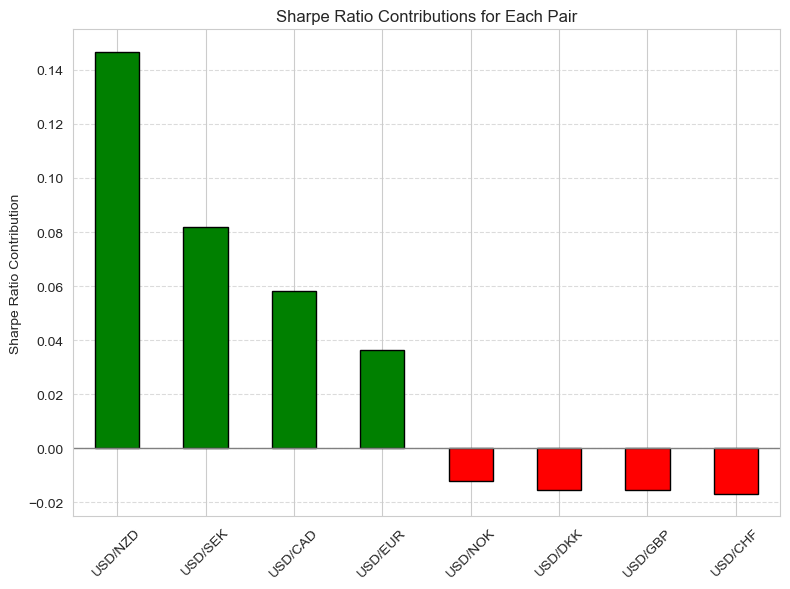

In [106]:
colors = sharpe_contributions_df['Sharpe Contribution'].apply(lambda x: 'green' if x > 0 else 'red')

plt.figure(figsize=(8,6))
sharpe_contributions_df['Sharpe Contribution'].plot(
    kind='bar', 
    color=colors, 
    edgecolor='black'
)
plt.title('Sharpe Ratio Contributions for Each Pair')
plt.ylabel('Sharpe Ratio Contribution')
plt.axhline(0, color='grey', linewidth=1)
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

*Even distribution of contributors, yet positive ones have significanty greater contribution which is good thing* 

## Out Of Sample Analysis 2021-2025


In [108]:
start_date = '2021-01-01'
fx_data_oos = fx_data.loc[start_date:] 
cpi_data_oos = cpi_data.loc[start_date:]
cpi_data_oos.drop(cpi_data_oos.tail(1).index,inplace=True) #cpi for april is not updated
fx_data_oos.drop(fx_data_oos.tail(1).index,inplace=True)

cpi_normalised_oos = cpi_data_oos / cpi_data_oos.iloc[0] * 100
cpi_lagged_oos = cpi_normalised_oos.shift(1)
cpi_lagged2_oos = cpi_normalised_oos.shift(2)
fx_lagged_oos = fx_data_oos.shift(1)
cpi_lagged_oos.drop(cpi_lagged_oos.head(1).index,inplace=True)
common_dates = cpi_lagged_oos.index.intersection(fx_data_oos.index)
cpi_lagged_oos = cpi_lagged_oos.loc[common_dates]
fx_monthly_oos = fx_data_oos.loc[common_dates]
print(fx_monthly_oos.shape)
print(cpi_lagged_oos.head())

(50, 8)
                   USD         EUR         GBP         CAD         CHF  \
Unnamed: 0                                                               
2021-02-01  100.000000  100.000000  100.000000  100.000000  100.000000   
2021-03-01  100.355621  100.208887  100.091491  100.506450  100.164413   
2021-04-01  100.840698  101.148880  100.365965  101.012991  100.502213   
2021-05-01  101.517673  101.728067  101.006404  101.519532  100.711892   
2021-06-01  102.195028  101.993923  101.555352  102.025982  100.978104   

                   SEK         NOK         NZD         DKK  
Unnamed: 0                                                  
2021-02-01  100.000000  100.000000  100.000000  100.000000  
2021-03-01  100.272112  100.701139  100.511733  100.579151  
2021-04-01  100.428836  100.438212  100.017111  100.675676  
2021-05-01  100.674348  100.788782  100.984893  101.061776  
2021-06-01  100.872500  100.701139  101.290707  101.254826  


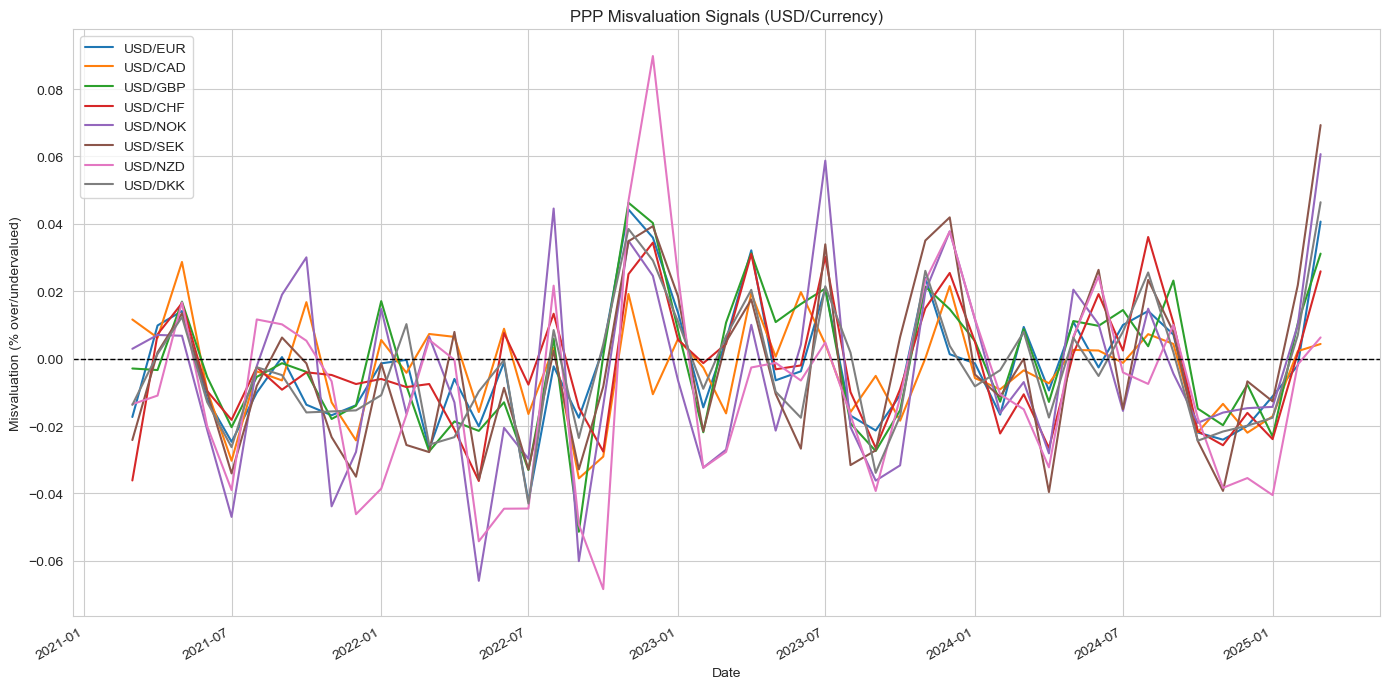

In [109]:
signals_oos = signal_generate(fx_monthly_oos,fx_lagged_oos,cpi_lagged_oos,cpi_lagged2_oos)
signals_oos.index.name = None
signals_oos.index = pd.to_datetime(signals_oos.index)
signals_oos.index = signals_oos.index.to_period("M")

plt.figure(figsize=(14, 7))
for column in signals_oos.columns:
    plt.plot(signals_oos.index.to_timestamp(), signals_oos[column], label=column)

plt.axhline(0, color='black', linewidth=1, linestyle='--')
plt.title('PPP Misvaluation Signals (USD/Currency)')
plt.xlabel('Date')
plt.ylabel('Misvaluation (% over/undervalued)')
plt.legend()
plt.tight_layout()
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

In [110]:
pairs = full_df.columns.levels[0]  
new_data = {}
for pair in pairs:
    spot_col = (pair, "spot USD base")
    fwd_col  = (pair, "fwd USD base")

    roll_list = []

    for i in range(len(full_df)):
        if i == len(full_df)-1:
            roll_list.append(np.nan)
        else:
            fwd_tmr = full_df.iloc[i+1][fwd_col]
            fwd_today = full_df.iloc[i][fwd_col]
            # spot_today = full_df.iloc[i][spot_col]
            # fwd_yesterday = full_df.iloc[i-1][fwd_col]
            # spot_yesterday = full_df.iloc[i-1][spot_col]
            val2 = (fwd_tmr - fwd_today) / fwd_today
            # val = (fwd_today - fwd_yesterday) / fwd_yesterday
            roll_list.append(val2)

    new_data[pair] = roll_list

excess_fx_returns = pd.DataFrame(new_data, index=full_df.index)
excess_fx_returns = excess_fx_returns[["USD/EUR", "USD/CAD", "USD/GBP", "USD/CHF", "USD/NOK", "USD/SEK", "USD/NZD", "USD/DKK"]]
excess_fx_returns_oos = excess_fx_returns.loc[signals_oos.index]
print(excess_fx_returns_oos)

          USD/EUR   USD/CAD   USD/GBP   USD/CHF   USD/NOK   USD/SEK   USD/NZD  \
2021-02  0.015916  0.000203  0.015225 -0.010001  0.035333  0.016193  0.000513   
2021-03 -0.005067  0.001416  0.001368 -0.005940 -0.008464 -0.005263 -0.014376   
2021-04 -0.014934 -0.016942 -0.013528 -0.029532 -0.020745 -0.015079 -0.009947   
2021-05  0.008121  0.004219  0.016682  0.007904  0.005650  0.008292  0.013913   
2021-06  0.019240  0.015693  0.017927  0.025366  0.010615  0.019116  0.043879   
2021-07  0.004552  0.000799  0.000310  0.005523 -0.002981  0.004582  0.006266   
2021-08  0.000213  0.004729 -0.010577  0.005731  0.008933  0.000172 -0.021393   
2021-09  0.014244  0.002300 -0.001366 -0.018708 -0.000100  0.014573 -0.023067   
2021-10  0.016125  0.017721  0.006622  0.010682 -0.001530  0.015938  0.033295   
2021-11  0.009366  0.011210  0.034180  0.018039 -0.001020  0.009349  0.027767   
2021-12 -0.000655 -0.017726  0.006679 -0.013423 -0.001414 -0.000234 -0.014462   
2022-01 -0.002742  0.001230 

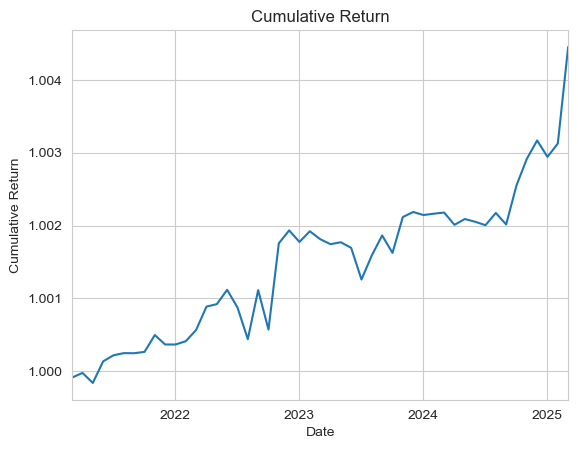

{'portfolio_cum_returns': 1.0044515673947623, 'ann_return': 0.0010890298063062076, 'ann_vol': 0.0011758078748607544, 'sharpe': -7.5785937347537145, 'max_drawdown(%)': -0.06760949351717338}


In [111]:
strategy_returns_per_pair_oos = (-signals_oos * excess_fx_returns_oos)
strategy_returns_oos = strategy_returns_per_pair_oos.mean(axis=1).dropna()
stats = aqms.evaluate_strategy(strategy_returns_oos)
print(stats)

## Normalised signal with 3M_0.2(Threshold) Filter

OOS analysis


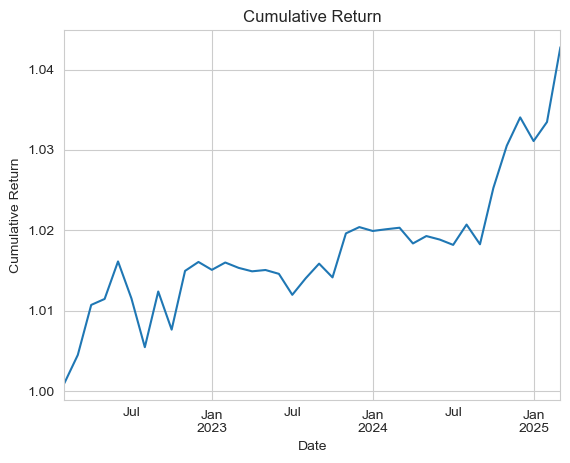

{'portfolio_cum_returns': 1.0427854135693027, 'ann_return': 0.013390153532535143, 'ann_vol': 0.01210812020283062, 'sharpe': 0.2799900790332918, 'max_drawdown(%)': -1.0488423992130236}


In [112]:
fx_monthly_oos.index = pd.to_datetime(fx_monthly_oos.index).to_period('M')
rolling_vol = strategy_returns_oos.rolling(window=12).std()
target_vol_monthly = 0.01 / (12 ** 0.5)
scale_factor = target_vol_monthly / rolling_vol
positions_scaled = -signals_oos.mul(scale_factor, axis=0)
momentum = fx_monthly_oos.pct_change(3 - 1)
momentum_filter = (momentum > -0.2)
# Align and forward-fill to match signal index
aligned_filter = momentum_filter.reindex(positions_scaled.index).ffill()
# Apply filter
signals_filtered = positions_scaled * aligned_filter.astype(float)
strategy_returns_scaled_oos = (signals_filtered * excess_fx_returns_oos).mean(axis=1).dropna()
print("OOS analysis")
stats_normalised_oos = aqms.evaluate_strategy(strategy_returns_scaled_oos)
print(stats_normalised_oos)

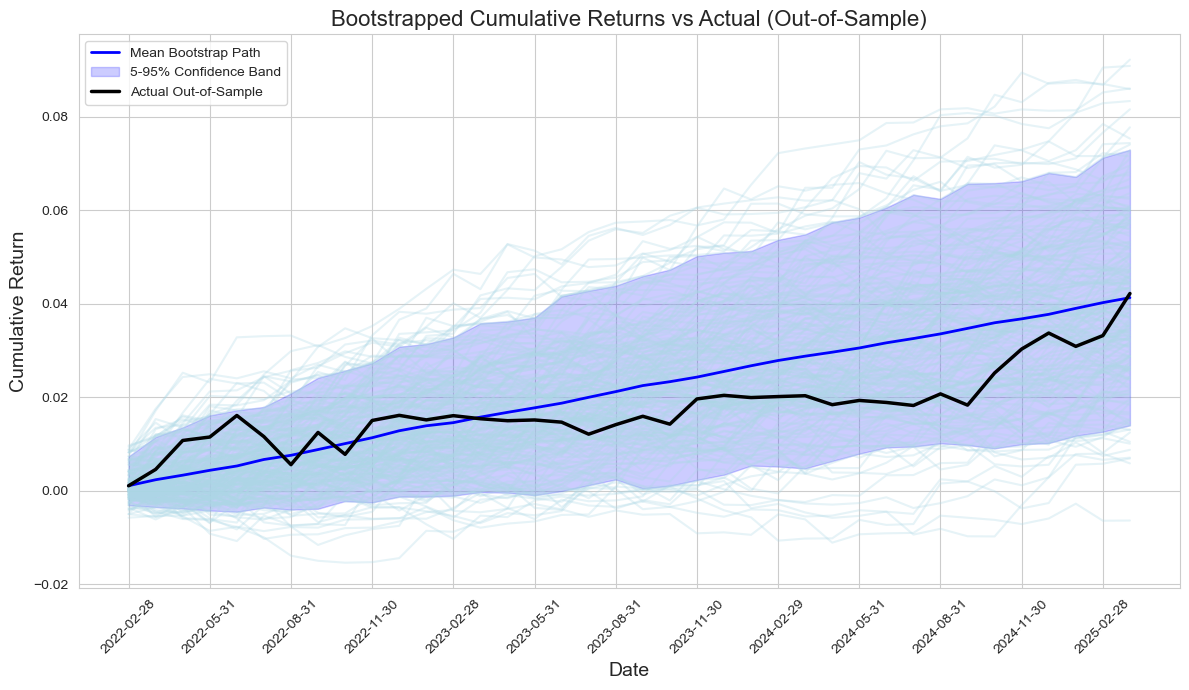

In [113]:
aqms.plot_bootstrapped_rtns(strategy_returns_scaled,strategy_returns_scaled_oos,num_bootstraps=200)

## Histogram of In-Sample returns

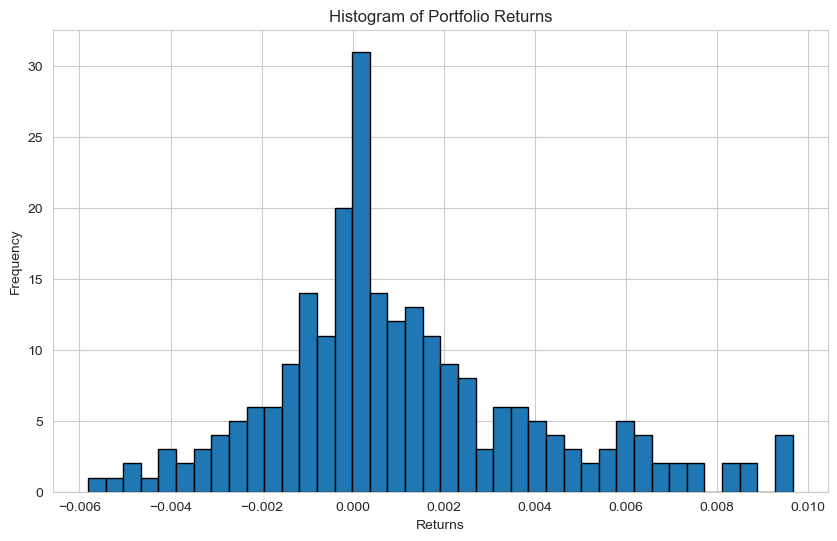

In [114]:
# Histogram of insample returns
plt.figure(figsize=(10, 6))
plt.hist(strategy_returns_scaled, bins=40, edgecolor='k', alpha=1)
plt.title('Histogram of Portfolio Returns')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Histogram of Out-Of-Sample Returns


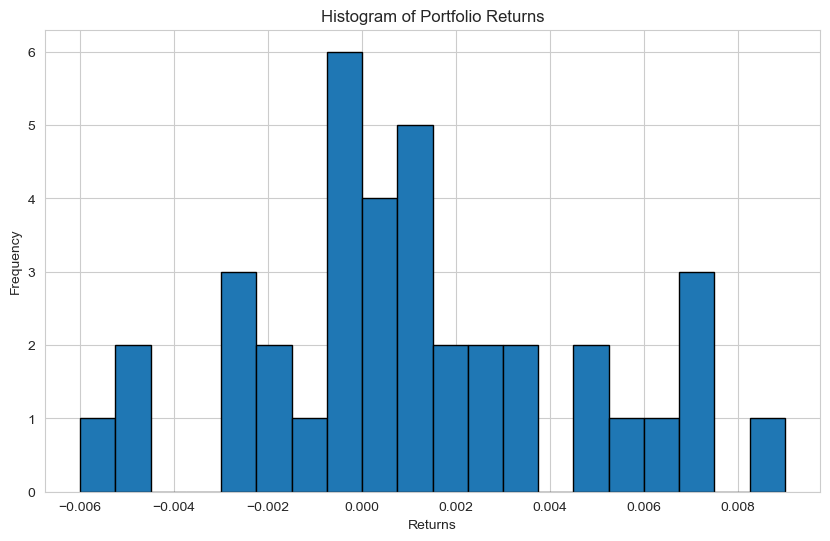

In [115]:
# Histogram of insample returns
plt.figure(figsize=(10, 6))
plt.hist(strategy_returns_scaled_oos, bins=20, edgecolor='k', alpha=1)
plt.title('Histogram of Portfolio Returns')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()